# Project: Analysis of Climate Change (Temperature) Impact on Agricultural Productivity

### Kha-Ai Tran

## Import Packages

In [1]:
#Foundational libraries
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import geopandas as gpd
import cenpy as cen
import matplotlib.pyplot as plt
import matplotlib as mpl
import shapely
import seaborn as sns
%matplotlib inline

#Needed for spatial statistics
import libpysal.weights as sw #spatial weights
from esda.moran import Moran, Moran_Local #global & local Moran's I
import spreg #spatial regression module
from mgwr.gwr import GWR, MGWR #GWR & MGWR constructors
from mgwr.sel_bw import Sel_BW #bandwidth selection constructor
from mgwr.utils import compare_surfaces, truncate_colormap, shift_colormap
from splot.esda import lisa_cluster, plot_local_autocorrelation

pd.options.display.max_rows = 50

## Data Setup and Exploration

In [2]:
farms = pd.read_csv('../data/usda_indices_farm_output_input_total_factor_productivity_1948_2017.csv')
farms.head()

,Year,Category1,Category2,Amount
0,1948,Total output,Total output,0.359295
1,1948,Livestock and products,All livestock and products,0.437911
2,1948,Livestock and products,Meat animals,0.563465
3,1948,Livestock and products,Dairy,0.448529
4,1948,Livestock and products,Poultry and eggs,0.131924


In [3]:
farms = farms[farms['Year'] >= 1960]
farms

,Year,Category1,Category2,Amount
360,1960,Total output,Total output,0.430512
361,1960,Livestock and products,All livestock and products,0.533655
362,1960,Livestock and products,Meat animals,0.709398
363,1960,Livestock and products,Dairy,0.547841
364,1960,Livestock and products,Poultry and eggs,0.233898
...,...,...,...,...
2095,2017,Intermediate goods,Fertilizer and lime,1.054148
2096,2017,Intermediate goods,Pesticides,1.061644
2097,2017,Intermediate goods,Purchased services,1.027826
2098,2017,Intermediate goods,Other intermediate,0.920118


In [4]:
farms['Category1'].unique()

array(['Total output', 'Livestock and products', 'Crops',
       'Farm-related output', 'Total farm inputs', 'Capital', 'Labor',
       'Intermediate goods', 'Total factor productivity (TFP)'],
      dtype=object)

In [5]:
farms['Category2'].unique()

array(['Total output', 'All livestock and products', 'Meat animals',
       'Dairy', 'Poultry and eggs', 'All crops', 'Food grains',
       'Feed crops', 'Oil crops', 'Vegetables and melons',
       'Fruits and nuts', 'Other crops', 'Farm-related output',
       'Total farm inputs', 'All capital', 'Durable equipment',
       'Service buildings', 'Land', 'Inventories', 'All labor',
       'Hired labor', 'Self-employed and unpaid family',
       'All intermediate goods', 'Feed and seed', 'Energy',
       'Fertilizer and lime', 'Pesticides', 'Purchased services',
       'Other intermediate', 'Total factor productivity (TFP)'],
      dtype=object)

In [6]:
farms=farms[farms["Category1"].str.contains("Total")==False]
farms

,Year,Category1,Category2,Amount
361,1960,Livestock and products,All livestock and products,0.533655
362,1960,Livestock and products,Meat animals,0.709398
363,1960,Livestock and products,Dairy,0.547841
364,1960,Livestock and products,Poultry and eggs,0.233898
365,1960,Crops,All crops,0.390497
...,...,...,...,...
2094,2017,Intermediate goods,Energy,0.959279
2095,2017,Intermediate goods,Fertilizer and lime,1.054148
2096,2017,Intermediate goods,Pesticides,1.061644
2097,2017,Intermediate goods,Purchased services,1.027826


In [7]:
farms_totals=farms[farms['Category2'].str.contains("All")==True]
farms_totals

,Year,Category1,Category2,Amount
361,1960,Livestock and products,All livestock and products,0.533655
365,1960,Crops,All crops,0.390497
374,1960,Capital,All capital,1.206107
379,1960,Labor,All labor,2.502950
382,1960,Intermediate goods,All intermediate goods,0.572199
...,...,...,...,...
2071,2017,Livestock and products,All livestock and products,1.053798
2075,2017,Crops,All crops,1.026259
2084,2017,Capital,All capital,0.986924
2089,2017,Labor,All labor,0.962226


In [8]:
farms=farms[farms["Category2"].str.contains("All")==False]
farms

,Year,Category1,Category2,Amount
362,1960,Livestock and products,Meat animals,0.709398
363,1960,Livestock and products,Dairy,0.547841
364,1960,Livestock and products,Poultry and eggs,0.233898
366,1960,Crops,Food grains,0.563863
367,1960,Crops,Feed crops,0.482751
...,...,...,...,...
2094,2017,Intermediate goods,Energy,0.959279
2095,2017,Intermediate goods,Fertilizer and lime,1.054148
2096,2017,Intermediate goods,Pesticides,1.061644
2097,2017,Intermediate goods,Purchased services,1.027826


In [9]:
farms['Category1'].unique()

array(['Livestock and products', 'Crops', 'Farm-related output',
       'Capital', 'Labor', 'Intermediate goods'], dtype=object)

In [10]:
farms_group = farms.groupby(['Year', 'Category1']).agg({'Amount': sum}).reset_index()

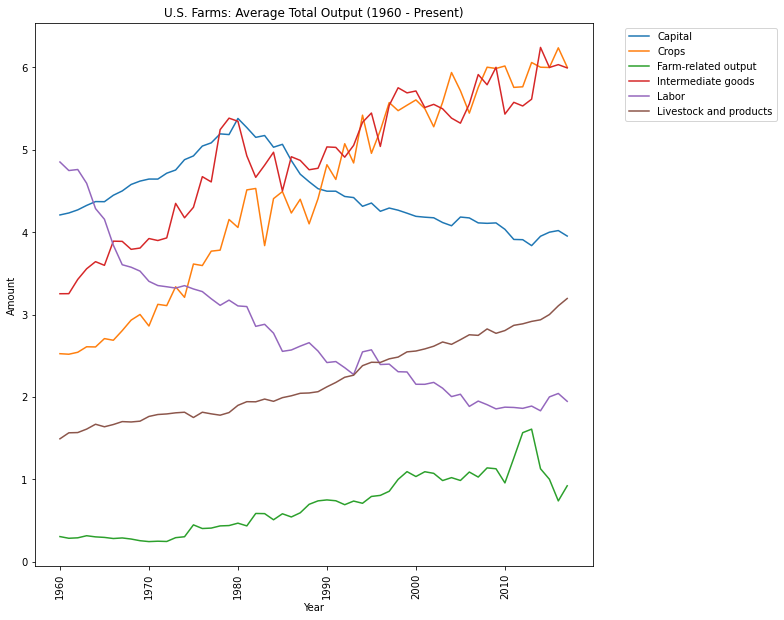

In [11]:
plt.figure(figsize=(10, 10))
sns.lineplot(x='Year', y='Amount', data=farms_group, hue='Category1')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.title('U.S. Farms: Average Total Output (1960 - Present)')
plt.show()

In [12]:
crops = pd.read_excel('../data/usda_state_crop_output.xls', header=5)
crops.head()

,Year,AL,AR,AZ,CA,CO,CT,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1960,0.863020,1.314405,0.875944,7.509311,1.102172,0.215666,0.123330,1.945921,1.163326,...,1.449408,1.130223,4.025687,0.222890,1.052029,0.157945,1.344930,1.957167,0.186453,0.209497
3,1961,0.816691,1.349605,0.915370,7.343501,1.062330,0.212578,0.119244,2.152937,1.233699,...,1.159234,1.179595,3.932670,0.209571,1.089893,0.162998,1.348380,2.097352,0.183341,0.226525
4,1962,0.738305,1.394829,0.894125,7.728201,0.954135,0.209983,0.113501,2.467778,1.128436,...,1.365035,1.099682,3.671237,0.243141,1.126861,0.154980,1.462482,2.154249,0.172485,0.226393


In [13]:
crops=crops.dropna()
crops

,Year,AL,AR,AZ,CA,CO,CT,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
2,1960,0.863020,1.314405,0.875944,7.509311,1.102172,0.215666,0.123330,1.945921,1.163326,...,1.449408,1.130223,4.025687,0.222890,1.052029,0.157945,1.344930,1.957167,0.186453,0.209497
3,1961,0.816691,1.349605,0.915370,7.343501,1.062330,0.212578,0.119244,2.152937,1.233699,...,1.159234,1.179595,3.932670,0.209571,1.089893,0.162998,1.348380,2.097352,0.183341,0.226525
4,1962,0.738305,1.394829,0.894125,7.728201,0.954135,0.209983,0.113501,2.467778,1.128436,...,1.365035,1.099682,3.671237,0.243141,1.126861,0.154980,1.462482,2.154249,0.172485,0.226393
5,1963,0.935998,1.456042,0.968581,7.886969,0.831364,0.218605,0.109854,2.010038,1.386955,...,1.417146,1.213836,4.090695,0.237186,0.879029,0.151962,1.598017,1.968646,0.162256,0.254502
6,1964,0.897049,1.527136,0.866725,8.307314,0.837551,0.211611,0.098910,1.956158,1.270681,...,1.154879,1.321503,3.797986,0.234716,1.031948,0.146725,1.663164,1.903562,0.163224,0.242913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,1973-79,6.016823,3.529687,5.164850,4.731929,3.632457,2.132750,2.578253,2.799821,4.033908,...,3.161453,4.002326,1.983880,3.635694,0.316761,2.523454,4.817531,5.111077,-2.086858,1.943745
56,1979-81,9.261720,4.303489,5.510485,3.456506,3.980310,-5.754362,-2.756580,3.997712,-0.058333,...,-1.341701,6.500423,0.486462,2.911569,5.552920,2.381916,8.948738,3.052310,0.543838,4.617399
57,1981-90,-5.536713,0.168547,-2.610574,2.075544,0.763145,2.759017,3.081671,0.904875,-2.008736,...,2.817128,-1.098648,-1.788194,-0.374451,0.011784,-1.066374,2.094235,-0.083751,1.920993,-0.147566
58,1990-2000,-0.508991,1.199811,3.301914,2.312445,1.482687,3.382866,1.645111,2.486331,3.342180,...,4.114096,0.919690,0.265719,1.884094,0.632065,-1.421405,1.936939,0.722594,0.789888,0.191076


In [14]:
crops.tail(15)

,Year,AL,AR,AZ,CA,CO,CT,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
41,1999,0.945225,3.128073,1.639767,20.852382,2.320511,0.281211,0.209848,5.781125,2.458056,...,4.263340,1.703972,7.077335,0.465342,1.211118,0.141490,4.525952,3.815473,0.159613,0.446254
42,2000,0.763403,2.859711,1.592129,22.039649,2.114670,0.326116,0.263059,6.102425,2.415683,...,4.350897,1.769697,5.316817,0.454637,1.374931,0.138423,4.588659,3.635645,0.209133,0.376173
43,2001,1.056083,3.300092,1.590440,21.278075,2.171840,0.287631,0.240448,6.020311,2.612800,...,4.039610,1.929036,5.997978,0.432824,1.345522,0.132935,4.489165,3.412757,0.199206,0.330989
44,2002,0.911699,3.326949,1.594406,22.996301,1.744101,0.309841,0.193805,5.688204,2.367527,...,3.037921,1.879152,6.458924,0.389753,1.186811,0.149296,4.320466,3.726374,0.197941,0.270746
45,2003,1.263035,3.803692,1.754357,22.225773,1.910930,0.291516,0.206023,5.687548,2.797096,...,3.884222,2.244980,6.661352,0.426307,1.328496,0.152133,4.398508,3.509442,0.205566,0.374374
46,2004,1.125317,3.608902,1.676865,22.716083,1.957250,0.306903,0.253655,5.953664,2.522851,...,4.502679,2.024221,7.062683,0.433164,1.431585,0.146873,4.551983,3.493665,0.211507,0.345135
51,1960-2004,0.603142,2.295499,1.475863,2.515749,1.305130,0.801817,1.638883,2.541526,1.759332,...,2.576175,1.324477,1.277567,1.510090,0.700140,-0.165186,2.770958,1.316939,0.286549,1.134611
52,1960-66,-3.422061,0.980051,0.378510,2.234830,-1.916480,0.023651,-3.975255,4.121260,-0.278839,...,-0.843636,-0.846891,1.006934,1.164083,-2.165615,0.119409,4.639681,1.988423,-7.109052,1.364202
53,1966-69,0.619256,5.987575,3.105513,2.305288,5.341445,-3.966248,13.218201,4.462648,2.101047,...,5.041082,1.249857,-2.063079,4.097253,5.304769,-2.765053,1.647264,0.473175,9.800194,7.395162
54,1969-73,1.676341,2.647625,-0.842275,2.559041,2.296394,-1.709603,1.451458,4.594513,7.252451,...,4.270201,2.461819,7.131480,2.224432,1.103642,-0.427057,1.231140,1.333881,2.744664,1.670884


In [15]:
crops=crops.head(45)
crops

,Year,AL,AR,AZ,CA,CO,CT,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
2,1960,0.863020,1.314405,0.875944,7.509311,1.102172,0.215666,0.123330,1.945921,1.163326,...,1.449408,1.130223,4.025687,0.222890,1.052029,0.157945,1.344930,1.957167,0.186453,0.209497
3,1961,0.816691,1.349605,0.915370,7.343501,1.062330,0.212578,0.119244,2.152937,1.233699,...,1.159234,1.179595,3.932670,0.209571,1.089893,0.162998,1.348380,2.097352,0.183341,0.226525
4,1962,0.738305,1.394829,0.894125,7.728201,0.954135,0.209983,0.113501,2.467778,1.128436,...,1.365035,1.099682,3.671237,0.243141,1.126861,0.154980,1.462482,2.154249,0.172485,0.226393
5,1963,0.935998,1.456042,0.968581,7.886969,0.831364,0.218605,0.109854,2.010038,1.386955,...,1.417146,1.213836,4.090695,0.237186,0.879029,0.151962,1.598017,1.968646,0.162256,0.254502
6,1964,0.897049,1.527136,0.866725,8.307314,0.837551,0.211611,0.098910,1.956158,1.270681,...,1.154879,1.321503,3.797986,0.234716,1.031948,0.146725,1.663164,1.903562,0.163224,0.242913
7,1965,0.921270,1.675313,0.926343,8.005043,0.818390,0.215163,0.136545,2.329985,1.348143,...,1.381165,1.261282,4.283360,0.252319,1.026239,0.132018,1.635818,2.044990,0.152710,0.220157
8,1966,0.702829,1.394014,0.896064,8.586863,0.982450,0.215972,0.097159,2.491814,1.144025,...,1.377868,1.074227,4.276401,0.239014,0.923840,0.159081,1.776637,2.205167,0.121709,0.227366
9,1967,0.616542,1.300783,0.851608,7.718895,0.928733,0.207115,0.149960,2.937796,1.399310,...,1.565086,0.998592,3.779990,0.283692,1.047327,0.156770,1.935799,2.221714,0.165703,0.298910
10,1968,0.660685,1.596347,0.894460,8.883205,1.050997,0.191068,0.116327,2.458111,1.214029,...,1.620280,1.034629,4.265132,0.267712,1.032268,0.145351,1.833613,2.388968,0.160302,0.288325
11,1969,0.716008,1.668315,0.983559,9.201735,1.153197,0.191744,0.144445,2.848779,1.218456,...,1.602828,1.115271,4.019748,0.270275,1.083208,0.146417,1.866641,2.236693,0.163308,0.283841


#### Temperature Data

In [16]:
globaltemp = pd.read_csv('../data/GlobalLandTemperaturesByCity.csv')
globaltemp

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
...,...,...,...,...,...,...,...
8599207,2013-05-01,11.464,0.236,Zwolle,Netherlands,52.24N,5.26E
8599208,2013-06-01,15.043,0.261,Zwolle,Netherlands,52.24N,5.26E
8599209,2013-07-01,18.775,0.193,Zwolle,Netherlands,52.24N,5.26E
8599210,2013-08-01,18.025,0.298,Zwolle,Netherlands,52.24N,5.26E


In [17]:
globaltemp.dtypes

dt                                object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
City                              object
Country                           object
Latitude                          object
Longitude                         object
dtype: object

In [18]:
# convert Date to datetime
globaltemp['dt']=pd.to_datetime(globaltemp['dt'],format='%Y-%m-%d')
globaltemp.dtypes

dt                               datetime64[ns]
AverageTemperature                      float64
AverageTemperatureUncertainty           float64
City                                     object
Country                                  object
Latitude                                 object
Longitude                                object
dtype: object

In [19]:
# data is already monthly
# select years since 1960 only to align with other datasets (and temperature/climate data needs longer timescale for more robust analysis)

globaltemp_1960 = globaltemp[globaltemp['dt'].dt.year >= 1960]
globaltemp_1960

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
2594,1960-01-01,-0.657,0.319,Århus,Denmark,57.05N,10.33E
2595,1960-02-01,-1.359,0.366,Århus,Denmark,57.05N,10.33E
2596,1960-03-01,2.339,0.360,Århus,Denmark,57.05N,10.33E
2597,1960-04-01,5.919,0.171,Århus,Denmark,57.05N,10.33E
2598,1960-05-01,12.214,0.334,Århus,Denmark,57.05N,10.33E
...,...,...,...,...,...,...,...
8599207,2013-05-01,11.464,0.236,Zwolle,Netherlands,52.24N,5.26E
8599208,2013-06-01,15.043,0.261,Zwolle,Netherlands,52.24N,5.26E
8599209,2013-07-01,18.775,0.193,Zwolle,Netherlands,52.24N,5.26E
8599210,2013-08-01,18.025,0.298,Zwolle,Netherlands,52.24N,5.26E


In [20]:
# select global temp data for united states only

globaltemp_1960 = globaltemp_1960[globaltemp_1960['Country'] == 'United States']
globaltemp_1960

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
49235,1960-01-01,5.243,0.300,Abilene,United States,32.95N,100.53W
49236,1960-02-01,4.995,0.325,Abilene,United States,32.95N,100.53W
49237,1960-03-01,8.575,0.303,Abilene,United States,32.95N,100.53W
49238,1960-04-01,18.452,0.282,Abilene,United States,32.95N,100.53W
49239,1960-05-01,21.709,0.286,Abilene,United States,32.95N,100.53W
...,...,...,...,...,...,...,...
8439242,2013-05-01,15.544,0.281,Yonkers,United States,40.99N,74.56W
8439243,2013-06-01,20.892,0.273,Yonkers,United States,40.99N,74.56W
8439244,2013-07-01,24.722,0.279,Yonkers,United States,40.99N,74.56W
8439245,2013-08-01,21.001,0.323,Yonkers,United States,40.99N,74.56W


In [21]:
# reformat lat long
globaltemp_1960=globaltemp_1960.copy()
globaltemp_1960['Latitude']=globaltemp_1960['Latitude'].str.rstrip('N')
globaltemp_1960['Latitude']=globaltemp_1960['Latitude'].astype(float)
globaltemp_1960['Longitude']=globaltemp_1960['Longitude'].str.rstrip('W')
globaltemp_1960['Longitude']=globaltemp_1960['Longitude'].astype(float)
globaltemp_1960['Longitude']=globaltemp_1960['Longitude']*-1
globaltemp_1960

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
49235,1960-01-01,5.243,0.300,Abilene,United States,32.95,-100.53
49236,1960-02-01,4.995,0.325,Abilene,United States,32.95,-100.53
49237,1960-03-01,8.575,0.303,Abilene,United States,32.95,-100.53
49238,1960-04-01,18.452,0.282,Abilene,United States,32.95,-100.53
49239,1960-05-01,21.709,0.286,Abilene,United States,32.95,-100.53
...,...,...,...,...,...,...,...
8439242,2013-05-01,15.544,0.281,Yonkers,United States,40.99,-74.56
8439243,2013-06-01,20.892,0.273,Yonkers,United States,40.99,-74.56
8439244,2013-07-01,24.722,0.279,Yonkers,United States,40.99,-74.56
8439245,2013-08-01,21.001,0.323,Yonkers,United States,40.99,-74.56


In [22]:
globaltemp_1960.dtypes

dt                               datetime64[ns]
AverageTemperature                      float64
AverageTemperatureUncertainty           float64
City                                     object
Country                                  object
Latitude                                float64
Longitude                               float64
dtype: object

In [23]:
usatemp_gdf = gpd.GeoDataFrame(
    globaltemp_1960, geometry=gpd.points_from_xy(x=globaltemp_1960.Longitude, y=globaltemp_1960.Latitude)
)
usatemp_gdf

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,geometry
49235,1960-01-01,5.243,0.300,Abilene,United States,32.95,-100.53,POINT (-100.53000 32.95000)
49236,1960-02-01,4.995,0.325,Abilene,United States,32.95,-100.53,POINT (-100.53000 32.95000)
49237,1960-03-01,8.575,0.303,Abilene,United States,32.95,-100.53,POINT (-100.53000 32.95000)
49238,1960-04-01,18.452,0.282,Abilene,United States,32.95,-100.53,POINT (-100.53000 32.95000)
49239,1960-05-01,21.709,0.286,Abilene,United States,32.95,-100.53,POINT (-100.53000 32.95000)
...,...,...,...,...,...,...,...,...
8439242,2013-05-01,15.544,0.281,Yonkers,United States,40.99,-74.56,POINT (-74.56000 40.99000)
8439243,2013-06-01,20.892,0.273,Yonkers,United States,40.99,-74.56,POINT (-74.56000 40.99000)
8439244,2013-07-01,24.722,0.279,Yonkers,United States,40.99,-74.56,POINT (-74.56000 40.99000)
8439245,2013-08-01,21.001,0.323,Yonkers,United States,40.99,-74.56,POINT (-74.56000 40.99000)


In [24]:
usatemp_gdf = usatemp_gdf.set_crs(epsg=4326)

In [25]:
usatemp_gdf = usatemp_gdf.to_crs(epsg=3395)

In [26]:
statetemp = pd.read_csv('../data/GlobalLandTemperaturesByState.csv')
statetemp

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil
...,...,...,...,...,...
645670,2013-05-01,21.634,0.578,Zhejiang,China
645671,2013-06-01,24.679,0.596,Zhejiang,China
645672,2013-07-01,29.272,1.340,Zhejiang,China
645673,2013-08-01,29.202,0.869,Zhejiang,China


In [27]:
# convert Date to datetime
statetemp['dt']=pd.to_datetime(statetemp['dt'],format='%Y-%m-%d')
statetemp.dtypes

dt                               datetime64[ns]
AverageTemperature                      float64
AverageTemperatureUncertainty           float64
State                                    object
Country                                  object
dtype: object

In [28]:
# data is already monthly
# select years since 1960 only

statetemp_1960 = statetemp[statetemp['dt'].dt.year >= 1960]
statetemp_1960

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
1256,1960-01-01,26.454,0.337,Acre,Brazil
1257,1960-02-01,26.157,0.445,Acre,Brazil
1258,1960-03-01,26.418,0.316,Acre,Brazil
1259,1960-04-01,25.393,0.298,Acre,Brazil
1260,1960-05-01,24.852,0.278,Acre,Brazil
...,...,...,...,...,...
645670,2013-05-01,21.634,0.578,Zhejiang,China
645671,2013-06-01,24.679,0.596,Zhejiang,China
645672,2013-07-01,29.272,1.340,Zhejiang,China
645673,2013-08-01,29.202,0.869,Zhejiang,China


In [29]:
# select global state temp data for united states only

statetemp_1960 = statetemp_1960[statetemp_1960['Country'] == 'United States']
statetemp_1960

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
10052,1960-01-01,7.173,0.219,Alabama,United States
10053,1960-02-01,7.022,0.221,Alabama,United States
10054,1960-03-01,7.631,0.099,Alabama,United States
10055,1960-04-01,17.858,0.239,Alabama,United States
10056,1960-05-01,20.071,0.305,Alabama,United States
...,...,...,...,...,...
626435,2013-05-01,10.607,0.208,Wyoming,United States
626436,2013-06-01,16.267,0.276,Wyoming,United States
626437,2013-07-01,20.222,0.133,Wyoming,United States
626438,2013-08-01,19.621,0.217,Wyoming,United States


In [30]:
statetemp_1960['Year'] = pd.DatetimeIndex(statetemp_1960['dt']).year
statetemp_1960['Month'] = pd.DatetimeIndex(statetemp_1960['dt']).month
statetemp_1960

/tmp/ipykernel_151/667730947.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  statetemp_1960['Year'] = pd.DatetimeIndex(statetemp_1960['dt']).year
/tmp/ipykernel_151/667730947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  statetemp_1960['Month'] = pd.DatetimeIndex(statetemp_1960['dt']).month


,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country,Year,Month
10052,1960-01-01,7.173,0.219,Alabama,United States,1960,1
10053,1960-02-01,7.022,0.221,Alabama,United States,1960,2
10054,1960-03-01,7.631,0.099,Alabama,United States,1960,3
10055,1960-04-01,17.858,0.239,Alabama,United States,1960,4
10056,1960-05-01,20.071,0.305,Alabama,United States,1960,5
...,...,...,...,...,...,...,...
626435,2013-05-01,10.607,0.208,Wyoming,United States,2013,5
626436,2013-06-01,16.267,0.276,Wyoming,United States,2013,6
626437,2013-07-01,20.222,0.133,Wyoming,United States,2013,7
626438,2013-08-01,19.621,0.217,Wyoming,United States,2013,8


In [31]:
# make average annual temp
statetemp_grp = statetemp_1960.groupby(['Year', 'State'])['AverageTemperature'].mean().reset_index()
statetemp_grp

,Year,State,AverageTemperature
0,1960,Alabama,16.613667
1,1960,Alaska,-4.358917
2,1960,Arizona,15.537417
3,1960,Arkansas,15.133583
4,1960,California,14.671250
...,...,...,...
2749,2013,Virginia,14.731556
2750,2013,Washington,10.571778
2751,2013,West Virginia,13.029444
2752,2013,Wisconsin,8.085333


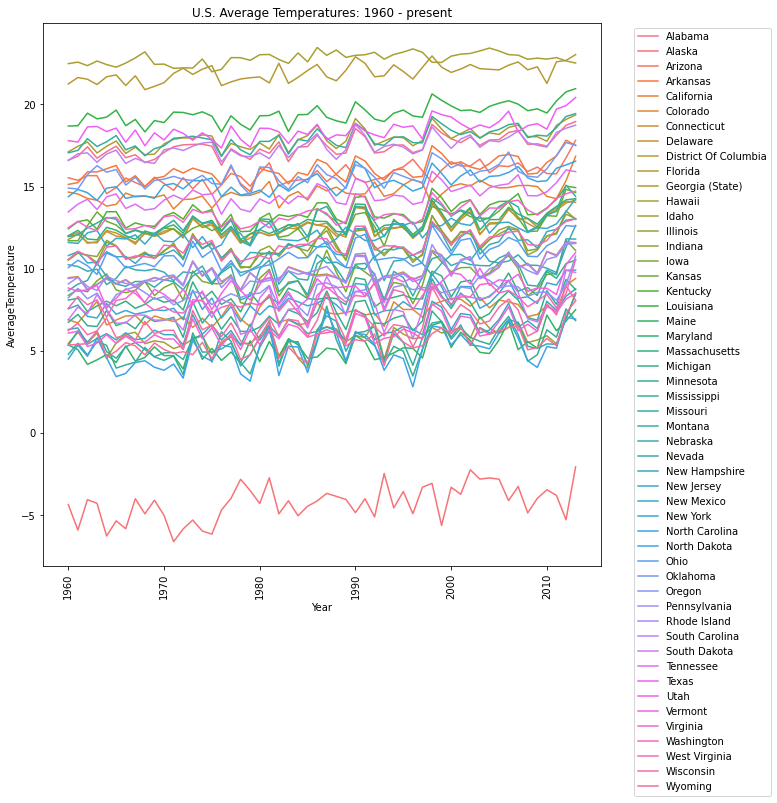

In [32]:
plt.figure(figsize=(10, 10))
sns.lineplot(x='Year', y='AverageTemperature', data=statetemp_grp, hue='State')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.title('U.S. Average Temperatures: 1960 - present')
plt.show()

In [33]:
statetemp_id = statetemp_1960[statetemp_1960['State'] == 'Idaho']
statetemp_id = statetemp_id.reset_index()
statetemp_id

,index,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country,Year,Month
0,169637,1960-01-01,-8.276,0.362,Idaho,United States,1960,1
1,169638,1960-02-01,-5.948,0.338,Idaho,United States,1960,2
2,169639,1960-03-01,0.148,0.240,Idaho,United States,1960,3
3,169640,1960-04-01,5.223,0.228,Idaho,United States,1960,4
4,169641,1960-05-01,8.684,0.372,Idaho,United States,1960,5
...,...,...,...,...,...,...,...,...
640,170277,2013-05-01,10.607,0.168,Idaho,United States,2013,5
641,170278,2013-06-01,15.136,0.277,Idaho,United States,2013,6
642,170279,2013-07-01,20.733,0.165,Idaho,United States,2013,7
643,170280,2013-08-01,19.559,0.235,Idaho,United States,2013,8


In [34]:
statetemp_id['Year'] = pd.DatetimeIndex(statetemp_id['dt']).year
statetemp_id['Month'] = pd.DatetimeIndex(statetemp_id['dt']).month
statetemp_id

,index,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country,Year,Month
0,169637,1960-01-01,-8.276,0.362,Idaho,United States,1960,1
1,169638,1960-02-01,-5.948,0.338,Idaho,United States,1960,2
2,169639,1960-03-01,0.148,0.240,Idaho,United States,1960,3
3,169640,1960-04-01,5.223,0.228,Idaho,United States,1960,4
4,169641,1960-05-01,8.684,0.372,Idaho,United States,1960,5
...,...,...,...,...,...,...,...,...
640,170277,2013-05-01,10.607,0.168,Idaho,United States,2013,5
641,170278,2013-06-01,15.136,0.277,Idaho,United States,2013,6
642,170279,2013-07-01,20.733,0.165,Idaho,United States,2013,7
643,170280,2013-08-01,19.559,0.235,Idaho,United States,2013,8


In [35]:
# make average annual temp
statetemp_id_grp = statetemp_id.groupby(['Year'])['AverageTemperature'].mean().reset_index()
statetemp_id_grp

,Year,AverageTemperature
0,1960,5.452000
1,1961,6.128583
2,1962,5.520917
3,1963,6.082000
4,1964,4.547417
...,...,...
49,2009,5.664250
50,2010,5.920167
51,2011,5.425667
52,2012,6.955833


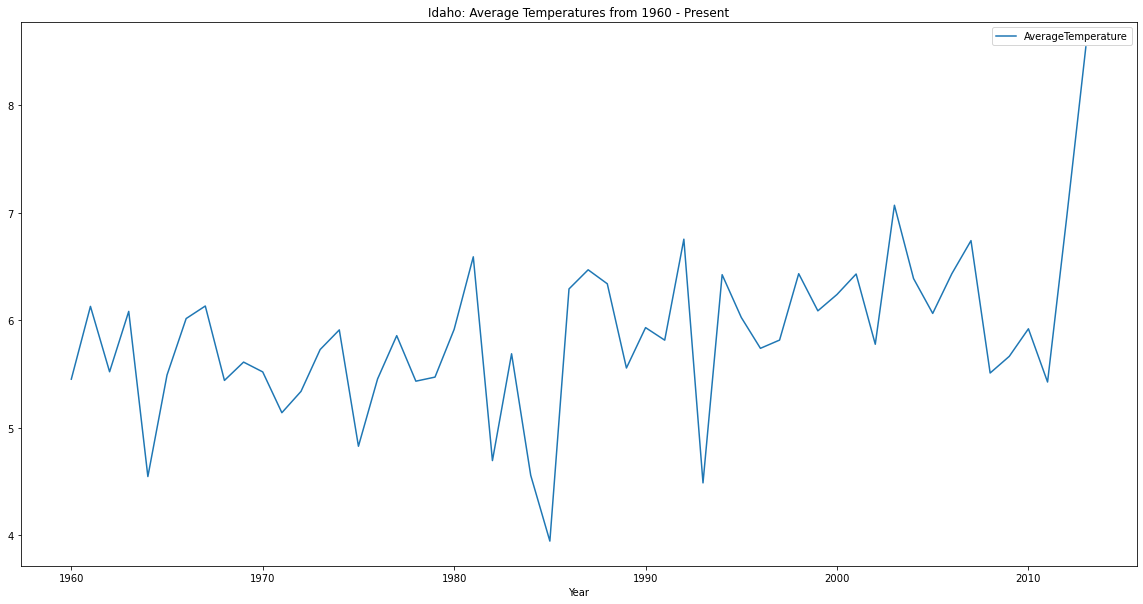

In [36]:
fig, ax = plt.subplots(figsize=(20,10))

statetemp_id_grp.plot(ax=ax,
                    x='Year',
                    y='AverageTemperature')

ax.set(title='Idaho: Average Temperatures from 1960 - Present')
plt.show()

In [37]:
state_ref = pd.read_csv('../data/state_abbs.csv')
state_ref

,State_N,State_Ab
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA
5,Colorado,CO
6,Connecticut,CT
7,Delaware,DE
8,Florida,FL
9,Georgia,GA


In [38]:
state_temp = statetemp_grp.merge(state_ref, left_on='State', right_on='State_N')
state_temp

,Year,State,AverageTemperature,State_N,State_Ab
0,1960,Alabama,16.613667,Alabama,AL
1,1961,Alabama,16.850917,Alabama,AL
2,1962,Alabama,17.426167,Alabama,AL
3,1963,Alabama,16.729750,Alabama,AL
4,1964,Alabama,17.126000,Alabama,AL
...,...,...,...,...,...
2641,2009,Wyoming,5.199917,Wyoming,WY
2642,2010,Wyoming,5.756417,Wyoming,WY
2643,2011,Wyoming,5.312250,Wyoming,WY
2644,2012,Wyoming,7.306167,Wyoming,WY


In [39]:
state_temp = state_temp.drop(columns=['State_N'])
state_temp

,Year,State,AverageTemperature,State_Ab
0,1960,Alabama,16.613667,AL
1,1961,Alabama,16.850917,AL
2,1962,Alabama,17.426167,AL
3,1963,Alabama,16.729750,AL
4,1964,Alabama,17.126000,AL
...,...,...,...,...
2641,2009,Wyoming,5.199917,WY
2642,2010,Wyoming,5.756417,WY
2643,2011,Wyoming,5.312250,WY
2644,2012,Wyoming,7.306167,WY


In [40]:
state_temp.dtypes

Year                    int64
State                  object
AverageTemperature    float64
State_Ab               object
dtype: object

In [41]:
livestock = pd.read_excel('../data/usda_livestock_output.xlsx', header=5)
livestock = livestock.dropna()
livestock

,Year,AL,AR,AZ,CA,CO,CT,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
2,1960,0.450464,0.320767,0.203055,1.546257,0.447052,0.090531,0.081866,0.261300,0.533815,...,0.580683,0.430724,1.461878,0.188581,0.361287,0.167176,0.271571,1.803398,0.127699,0.161523
3,1961,0.487183,0.382439,0.214538,1.639567,0.474570,0.089617,0.080212,0.270783,0.579638,...,0.644547,0.444122,1.520713,0.193553,0.371684,0.172574,0.281085,1.821798,0.124402,0.156513
4,1962,0.500488,0.388813,0.245871,1.734953,0.494968,0.087641,0.082095,0.282982,0.595167,...,0.654109,0.443011,1.591044,0.194365,0.361622,0.171309,0.284347,1.857005,0.118109,0.163105
5,1963,0.512270,0.421954,0.239095,1.736934,0.553478,0.086825,0.091447,0.297993,0.638344,...,0.691100,0.450699,1.602084,0.196505,0.367249,0.170741,0.284903,1.873435,0.113618,0.180531
6,1964,0.538191,0.457701,0.239859,1.727789,0.548633,0.088068,0.094451,0.315775,0.666640,...,0.712722,0.448625,1.587293,0.191812,0.357490,0.171669,0.289460,1.908336,0.112577,0.178518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,1973-79,0.572945,3.516437,-4.411904,0.895082,0.381619,0.650156,4.119364,0.536789,2.017074,...,-2.103181,-1.337516,-0.644533,-0.477804,4.162708,2.125385,4.316589,2.343920,1.344777,0.688124
56,1979-81,0.524351,1.074259,-3.695965,0.623758,-6.708215,2.186999,-0.255393,-0.712308,7.314735,...,2.148594,-0.560648,-1.516252,6.188110,1.575418,0.981440,3.166909,1.085760,0.566131,-0.851746
57,1981-90,3.081435,3.546829,0.506050,2.606441,1.214462,0.560791,4.188962,1.016558,-0.093679,...,-0.882371,-1.069422,2.113278,1.415358,2.056234,-0.458833,2.395401,0.339243,1.416951,-0.581247
58,1990-2000,1.463700,1.808149,3.457022,2.442482,2.989242,0.828211,2.336711,0.877765,3.115710,...,0.667802,-0.418902,1.825122,3.185361,1.506698,1.647656,2.056530,-0.187775,2.104495,1.889660


In [42]:
livestock.tail(10)

,Year,AL,AR,AZ,CA,CO,CT,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
46,2004,1.164223,1.550567,0.451153,3.727383,1.085124,0.077141,0.280209,0.520748,1.592106,...,0.726806,0.421948,3.336220,0.352727,0.693008,0.199412,0.589877,2.020115,0.139117,0.224587
51,1960-2004,2.158026,3.581047,1.814385,1.999702,2.015396,-0.363780,2.796466,1.567265,2.483554,...,0.510124,-0.046788,1.875265,1.423109,1.480382,0.400739,1.762932,0.257913,0.194639,0.749132
52,1960-66,5.628921,8.924156,4.501910,2.876020,5.243845,-0.551024,3.562159,4.805735,5.989053,...,3.777428,1.466876,2.254887,1.045592,-0.118852,-0.504710,1.819901,-0.086332,-2.995544,2.541964
53,1966-69,2.763746,5.161253,10.606365,1.104283,6.436446,-3.698365,3.640794,5.962874,4.108301,...,-0.049313,0.760710,4.077489,0.036912,1.420455,0.239766,-2.023624,-0.939452,-4.114792,0.707273
54,1969-73,1.478708,3.096447,3.701725,1.369329,5.058577,-1.373052,1.359912,2.992564,0.316877,...,3.121885,1.626583,6.535645,0.337775,0.498684,0.319252,4.274342,0.100109,-0.101725,1.007114
55,1973-79,0.572945,3.516437,-4.411904,0.895082,0.381619,0.650156,4.119364,0.536789,2.017074,...,-2.103181,-1.337516,-0.644533,-0.477804,4.162708,2.125385,4.316589,2.343920,1.344777,0.688124
56,1979-81,0.524351,1.074259,-3.695965,0.623758,-6.708215,2.186999,-0.255393,-0.712308,7.314735,...,2.148594,-0.560648,-1.516252,6.188110,1.575418,0.981440,3.166909,1.085760,0.566131,-0.851746
57,1981-90,3.081435,3.546829,0.506050,2.606441,1.214462,0.560791,4.188962,1.016558,-0.093679,...,-0.882371,-1.069422,2.113278,1.415358,2.056234,-0.458833,2.395401,0.339243,1.416951,-0.581247
58,1990-2000,1.463700,1.808149,3.457022,2.442482,2.989242,0.828211,2.336711,0.877765,3.115710,...,0.667802,-0.418902,1.825122,3.185361,1.506698,1.647656,2.056530,-0.187775,2.104495,1.889660
59,2000-04,0.029315,0.725379,0.233544,1.859957,-3.006286,-4.429253,0.009088,-2.364101,0.675940,...,-0.743378,0.827960,0.059069,0.195050,-0.526587,-2.099444,-4.683534,-0.781599,-0.927450,-1.132726


In [43]:
livestock = livestock.head(45)
livestock

,Year,AL,AR,AZ,CA,CO,CT,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
2,1960,0.450464,0.320767,0.203055,1.546257,0.447052,0.090531,0.081866,0.261300,0.533815,...,0.580683,0.430724,1.461878,0.188581,0.361287,0.167176,0.271571,1.803398,0.127699,0.161523
3,1961,0.487183,0.382439,0.214538,1.639567,0.474570,0.089617,0.080212,0.270783,0.579638,...,0.644547,0.444122,1.520713,0.193553,0.371684,0.172574,0.281085,1.821798,0.124402,0.156513
4,1962,0.500488,0.388813,0.245871,1.734953,0.494968,0.087641,0.082095,0.282982,0.595167,...,0.654109,0.443011,1.591044,0.194365,0.361622,0.171309,0.284347,1.857005,0.118109,0.163105
5,1963,0.512270,0.421954,0.239095,1.736934,0.553478,0.086825,0.091447,0.297993,0.638344,...,0.691100,0.450699,1.602084,0.196505,0.367249,0.170741,0.284903,1.873435,0.113618,0.180531
6,1964,0.538191,0.457701,0.239859,1.727789,0.548633,0.088068,0.094451,0.315775,0.666640,...,0.712722,0.448625,1.587293,0.191812,0.357490,0.171669,0.289460,1.908336,0.112577,0.178518
7,1965,0.580973,0.488559,0.259743,1.822702,0.552958,0.088644,0.093976,0.324411,0.704304,...,0.709452,0.452851,1.625987,0.189299,0.355722,0.172147,0.302139,1.807422,0.110428,0.180900
8,1966,0.631447,0.547939,0.266025,1.837486,0.612351,0.087587,0.101374,0.348631,0.764630,...,0.728401,0.470352,1.673664,0.200790,0.358720,0.162190,0.302904,1.794081,0.106692,0.188136
9,1967,0.644341,0.588214,0.280468,1.896197,0.698999,0.084500,0.104594,0.380683,0.802381,...,0.774006,0.481364,1.717567,0.200004,0.358997,0.158174,0.291582,1.785474,0.103290,0.197318
10,1968,0.653615,0.605480,0.314590,1.894127,0.681078,0.081803,0.096406,0.396357,0.815704,...,0.771329,0.477121,1.733741,0.199744,0.364057,0.159683,0.296108,1.783164,0.098983,0.197771
11,1969,0.686033,0.639702,0.365689,1.899379,0.742779,0.078389,0.113074,0.416922,0.864924,...,0.727324,0.481209,1.891442,0.201013,0.374337,0.163360,0.285062,1.744223,0.094302,0.192170


In [44]:
pesticide = pd.read_excel('../data/usda_pesticide_input.xlsx', header=5)
pesticide.columns

Index(['Year', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'IA',
       'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO',
       'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK',
       'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI',
       'WV', 'WY', 'Unnamed: 49', 'Unnamed: 50', 'Unnamed: 51', 'Unnamed: 52',
       'Unnamed: 53', 'Unnamed: 54', 'Unnamed: 55', 'Unnamed: 56',
       'Unnamed: 57', 'Unnamed: 58', 'Unnamed: 59', 'Unnamed: 60',
       'Unnamed: 61', 'Unnamed: 62', 'Unnamed: 63', 'Unnamed: 64'],
      dtype='object')

In [45]:
pesticide = pesticide.drop(columns=['Unnamed: 49', 'Unnamed: 50', 'Unnamed: 51', 'Unnamed: 52',
       'Unnamed: 53', 'Unnamed: 54', 'Unnamed: 55', 'Unnamed: 56',
       'Unnamed: 57', 'Unnamed: 58', 'Unnamed: 59', 'Unnamed: 60',
       'Unnamed: 61', 'Unnamed: 62', 'Unnamed: 63', 'Unnamed: 64'])
pesticide

,Year,AL,AR,AZ,CA,CO,CT,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1960,0.178484,0.106171,0.087280,1.062667,0.133525,0.034140,0.044995,0.779521,0.169806,...,0.101595,0.092337,0.485099,0.069292,0.180571,0.078544,0.705498,0.117415,0.079545,0.090811
3,1961,0.247011,0.167392,0.098225,1.094315,0.132701,0.034168,0.049297,0.744824,0.213233,...,0.122563,0.123432,0.674952,0.072814,0.199443,0.083884,0.858723,0.139824,0.090569,0.092019
4,1962,0.314190,0.254977,0.107444,1.108723,0.130355,0.031923,0.050118,0.782909,0.276845,...,0.137305,0.158171,0.856194,0.067527,0.215441,0.086322,0.990876,0.154301,0.100363,0.087985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,1973-79,10.462063,9.047761,10.593993,12.004515,11.758757,3.035230,12.607397,4.583463,9.847706,...,16.971792,14.805593,6.487497,9.254164,9.641652,5.169438,11.408569,12.912027,12.436573,5.658515
56,1979-81,-1.400593,5.347387,3.944790,7.749684,7.640326,2.863021,6.169259,3.261476,8.241764,...,4.446101,2.491801,3.367449,4.200298,5.003744,-11.869016,0.281304,6.521305,-9.504065,-5.282463
57,1981-90,-2.245352,3.360437,-2.972306,0.905633,1.085491,1.329006,-2.136154,3.137201,-2.956186,...,3.074134,0.057190,0.402944,0.191990,-1.612102,-2.633790,-1.178145,2.365646,-1.770276,-0.093298
58,1990-2000,0.922101,4.975249,3.525278,2.229700,3.806531,3.669560,2.648079,-1.471705,3.782412,...,7.725309,4.224510,3.837875,0.448343,2.160851,4.700115,-2.562794,4.609201,-4.141856,0.147413


In [46]:
pesticide = pesticide.dropna()

In [47]:
pesticide.tail(10)

,Year,AL,AR,AZ,CA,CO,CT,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
46,2004,1.042029,3.144619,0.841938,8.133400,0.735248,0.080110,0.181144,2.711322,2.024954,...,3.244875,1.541541,4.843303,0.100002,1.036892,0.078452,2.048215,2.329117,0.066102,0.100739
51,1960-2004,4.010056,7.700904,5.151319,4.625448,3.877087,1.938463,3.165311,2.832983,5.633289,...,7.872369,6.397943,5.229542,0.833772,3.972412,-0.002667,2.422319,6.789843,-0.420746,0.235819
52,1960-66,10.108244,21.032206,9.036106,-1.333441,0.147122,-4.894536,2.688247,-0.446330,16.608485,...,17.761765,10.333674,12.396462,-8.618110,3.301499,-10.957697,7.575075,15.211794,1.546462,-1.795203
53,1966-69,3.315953,11.216549,26.209441,22.177762,4.151492,16.696839,-0.812601,29.431444,8.802225,...,-16.088974,6.211886,11.100771,-0.758855,7.887171,-4.551321,20.950407,9.213661,-14.285716,-3.297927
54,1969-73,10.219433,8.158036,6.520993,7.977522,10.577328,-1.498648,8.373920,0.063343,5.599742,...,13.261955,12.782323,10.854842,9.489580,7.018617,10.893281,-5.022024,9.813787,-1.585888,6.104722
55,1973-79,10.462063,9.047761,10.593993,12.004515,11.758757,3.035230,12.607397,4.583463,9.847706,...,16.971792,14.805593,6.487497,9.254164,9.641652,5.169438,11.408569,12.912027,12.436573,5.658515
56,1979-81,-1.400593,5.347387,3.944790,7.749684,7.640326,2.863021,6.169259,3.261476,8.241764,...,4.446101,2.491801,3.367449,4.200298,5.003744,-11.869016,0.281304,6.521305,-9.504065,-5.282463
57,1981-90,-2.245352,3.360437,-2.972306,0.905633,1.085491,1.329006,-2.136154,3.137201,-2.956186,...,3.074134,0.057190,0.402944,0.191990,-1.612102,-2.633790,-1.178145,2.365646,-1.770276,-0.093298
58,1990-2000,0.922101,4.975249,3.525278,2.229700,3.806531,3.669560,2.648079,-1.471705,3.782412,...,7.725309,4.224510,3.837875,0.448343,2.160851,4.700115,-2.562794,4.609201,-4.141856,0.147413
59,2000-04,3.995847,0.346749,-3.056614,-1.224293,-4.680649,-0.507601,-0.788001,-2.189990,3.154982,...,4.847370,3.291381,-2.166433,-4.356014,7.071042,1.283515,-3.603573,-4.327851,5.787213,-4.349619


In [48]:
pesticide = pesticide.head(45)
pesticide

,Year,AL,AR,AZ,CA,CO,CT,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
2,1960,0.178484,0.106171,0.087280,1.062667,0.133525,0.034140,0.044995,0.779521,0.169806,...,0.101595,0.092337,0.485099,0.069292,0.180571,0.078544,0.705498,0.117415,0.079545,0.090811
3,1961,0.247011,0.167392,0.098225,1.094315,0.132701,0.034168,0.049297,0.744824,0.213233,...,0.122563,0.123432,0.674952,0.072814,0.199443,0.083884,0.858723,0.139824,0.090569,0.092019
4,1962,0.314190,0.254977,0.107444,1.108723,0.130355,0.031923,0.050118,0.782909,0.276845,...,0.137305,0.158171,0.856194,0.067527,0.215441,0.086322,0.990876,0.154301,0.100363,0.087985
5,1963,0.322252,0.272686,0.109641,1.036738,0.126061,0.026219,0.047197,0.667724,0.313717,...,0.146935,0.175893,1.021840,0.049770,0.207750,0.078187,1.276884,0.170272,0.116325,0.080529
6,1964,0.404092,0.340872,0.118347,1.031267,0.122670,0.021827,0.046154,0.702270,0.358204,...,0.173652,0.217140,1.087414,0.040229,0.227969,0.078390,1.466175,0.179696,0.107149,0.071911
7,1965,0.363715,0.328412,0.126760,0.950836,0.124206,0.023633,0.047779,0.681178,0.390485,...,0.214130,0.200027,0.994560,0.031849,0.202897,0.058755,1.520572,0.222946,0.104876,0.077636
8,1966,0.327338,0.375021,0.150099,0.980959,0.134709,0.025452,0.052871,0.758922,0.459971,...,0.294918,0.171651,1.020595,0.041316,0.220128,0.040699,1.111436,0.292487,0.087279,0.081538
9,1967,0.404394,0.526235,0.234195,1.519758,0.169566,0.040556,0.070307,1.276692,0.608416,...,0.312828,0.222388,1.451047,0.094172,0.284142,0.045198,1.673125,0.369853,0.101013,0.103437
10,1968,0.376847,0.496752,0.281349,1.762349,0.149624,0.035373,0.057279,1.479298,0.478004,...,0.245496,0.207700,1.440976,0.054424,0.273283,0.041232,1.527051,0.371105,0.081106,0.084151
11,1969,0.361576,0.525042,0.329500,1.908101,0.152576,0.042002,0.051597,1.835078,0.598982,...,0.182004,0.206814,1.423914,0.040386,0.278893,0.035504,2.083741,0.385612,0.056857,0.073857


In [49]:
energy = pd.read_excel('../data/usda_energy_input.xlsx', header=5)
energy.columns

Index(['Year', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'IA',
       'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO',
       'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK',
       'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI',
       'WV', 'WY', 'Unnamed: 49', 'Unnamed: 50', 'Unnamed: 51', 'Unnamed: 52',
       'Unnamed: 53', 'Unnamed: 54', 'Unnamed: 55', 'Unnamed: 56',
       'Unnamed: 57', 'Unnamed: 58', 'Unnamed: 59', 'Unnamed: 60',
       'Unnamed: 61', 'Unnamed: 62', 'Unnamed: 63', 'Unnamed: 64'],
      dtype='object')

In [50]:
energy = energy.drop(columns=['Unnamed: 49', 'Unnamed: 50', 'Unnamed: 51', 'Unnamed: 52',
       'Unnamed: 53', 'Unnamed: 54', 'Unnamed: 55', 'Unnamed: 56',
       'Unnamed: 57', 'Unnamed: 58', 'Unnamed: 59', 'Unnamed: 60',
       'Unnamed: 61', 'Unnamed: 62', 'Unnamed: 63', 'Unnamed: 64'])
energy = energy.dropna()
energy = energy.head(45)
energy

,Year,AL,AR,AZ,CA,CO,CT,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
2,1960,0.898525,1.726459,0.681424,5.089436,1.131987,0.160933,0.098529,0.842497,1.412659,...,1.611006,1.020673,6.257787,0.349966,0.921488,0.170680,1.377598,1.971020,0.235911,0.369047
3,1961,0.918041,1.753971,0.716768,5.573420,1.137502,0.163242,0.104050,0.878546,1.455220,...,1.625616,1.012615,6.346984,0.345231,0.870235,0.168004,1.427013,1.924042,0.229707,0.378130
4,1962,0.939338,1.790455,0.756092,5.518810,1.141354,0.167825,0.105304,0.960891,1.465340,...,1.639192,1.005289,6.380478,0.337865,0.914343,0.168061,1.407428,1.917315,0.229760,0.375116
5,1963,0.970191,1.869814,0.786799,5.529642,1.183112,0.180751,0.112125,1.006508,1.518619,...,1.711350,1.039959,6.622695,0.345901,0.924863,0.170003,1.425789,1.977929,0.243758,0.379000
6,1964,1.005091,1.910195,0.826302,5.522220,1.218111,0.188931,0.124589,1.039332,1.568922,...,1.795364,1.059269,6.937683,0.344635,0.971385,0.167047,1.446548,1.992900,0.230940,0.403921
7,1965,1.030791,1.914046,0.805510,5.439132,1.258188,0.182516,0.127557,1.072076,1.604336,...,1.780546,1.180695,7.085502,0.354278,1.017466,0.162034,1.447960,2.018165,0.311524,0.400513
8,1966,1.042934,1.948036,0.771024,5.415232,1.224446,0.174526,0.126711,1.102791,1.676833,...,1.851629,1.262187,7.151411,0.361446,1.053651,0.161838,1.496508,2.044348,0.235447,0.427731
9,1967,1.078183,1.934602,0.727002,5.065116,1.231950,0.165527,0.125351,1.119919,1.696287,...,1.891207,1.272516,7.201469,0.362714,1.070525,0.159975,1.475403,1.989503,0.241865,0.422094
10,1968,1.104818,1.984302,0.737477,4.905438,1.231921,0.159518,0.128637,1.143745,1.713065,...,1.847882,1.285975,7.175344,0.365112,1.082027,0.157637,1.461357,2.017179,0.227639,0.426016
11,1969,1.141053,1.998541,0.693732,5.284447,1.262915,0.153878,0.132478,1.243644,1.757899,...,1.887881,1.339614,7.296759,0.356119,1.096318,0.153979,1.523480,2.039793,0.227089,0.423335


## California

### California Data

In [51]:
# create dataframe for california only (size constraint for data analysis)
state_temp_ca = state_temp[state_temp['State_Ab'] == 'CA']
state_temp_ca

,Year,State,AverageTemperature,State_Ab
216,1960,California,14.671250,CA
217,1961,California,14.549333,CA
218,1962,California,14.281417,CA
219,1963,California,14.170750,CA
220,1964,California,13.812667,CA
...,...,...,...,...
265,2009,California,15.004250,CA
266,2010,California,14.408167,CA
267,2011,California,14.265750,CA
268,2012,California,15.358500,CA


In [52]:
# create dataframes for california only (size constraint for data analysis)
crops_ca = crops[['Year', 'CA']]
livestock_ca = livestock[['Year', 'CA']]
pesticide_ca = pesticide[['Year', 'CA']]
energy_ca = energy[['Year', 'CA']]

In [53]:
ca_data = state_temp_ca.merge(crops_ca, left_on='Year', right_on='Year')
ca_data

,Year,State,AverageTemperature,State_Ab,CA
0,1960,California,14.671250,CA,7.509311
1,1961,California,14.549333,CA,7.343501
2,1962,California,14.281417,CA,7.728201
3,1963,California,14.170750,CA,7.886969
4,1964,California,13.812667,CA,8.307314
5,1965,California,13.921083,CA,8.005043
6,1966,California,14.607250,CA,8.586863
7,1967,California,14.383917,CA,7.718895
8,1968,California,14.415417,CA,8.883205
9,1969,California,14.341917,CA,9.201735


In [54]:
ca_data=ca_data.rename(columns={"CA": "crop_output"})
ca_data

,Year,State,AverageTemperature,State_Ab,crop_output
0,1960,California,14.671250,CA,7.509311
1,1961,California,14.549333,CA,7.343501
2,1962,California,14.281417,CA,7.728201
3,1963,California,14.170750,CA,7.886969
4,1964,California,13.812667,CA,8.307314
5,1965,California,13.921083,CA,8.005043
6,1966,California,14.607250,CA,8.586863
7,1967,California,14.383917,CA,7.718895
8,1968,California,14.415417,CA,8.883205
9,1969,California,14.341917,CA,9.201735


In [55]:
ca_data = ca_data.merge(livestock_ca, left_on='Year', right_on='Year')
ca_data = ca_data.rename(columns={"CA": "livestock_output"})
ca_data

,Year,State,AverageTemperature,State_Ab,crop_output,livestock_output
0,1960,California,14.671250,CA,7.509311,1.546257
1,1961,California,14.549333,CA,7.343501,1.639567
2,1962,California,14.281417,CA,7.728201,1.734953
3,1963,California,14.170750,CA,7.886969,1.736934
4,1964,California,13.812667,CA,8.307314,1.727789
5,1965,California,13.921083,CA,8.005043,1.822702
6,1966,California,14.607250,CA,8.586863,1.837486
7,1967,California,14.383917,CA,7.718895,1.896197
8,1968,California,14.415417,CA,8.883205,1.894127
9,1969,California,14.341917,CA,9.201735,1.899379


In [56]:
ca_data = ca_data.merge(pesticide_ca, left_on='Year', right_on='Year')
ca_data = ca_data.rename(columns={"CA": "pesticide_input"})
ca_data

,Year,State,AverageTemperature,State_Ab,crop_output,livestock_output,pesticide_input
0,1960,California,14.671250,CA,7.509311,1.546257,1.062667
1,1961,California,14.549333,CA,7.343501,1.639567,1.094315
2,1962,California,14.281417,CA,7.728201,1.734953,1.108723
3,1963,California,14.170750,CA,7.886969,1.736934,1.036738
4,1964,California,13.812667,CA,8.307314,1.727789,1.031267
5,1965,California,13.921083,CA,8.005043,1.822702,0.950836
6,1966,California,14.607250,CA,8.586863,1.837486,0.980959
7,1967,California,14.383917,CA,7.718895,1.896197,1.519758
8,1968,California,14.415417,CA,8.883205,1.894127,1.762349
9,1969,California,14.341917,CA,9.201735,1.899379,1.908101


In [57]:
ca_data = ca_data.merge(energy_ca, left_on='Year', right_on='Year')
ca_data = ca_data.rename(columns={"CA": "energy_input"})
ca_data

,Year,State,AverageTemperature,State_Ab,crop_output,livestock_output,pesticide_input,energy_input
0,1960,California,14.671250,CA,7.509311,1.546257,1.062667,5.089436
1,1961,California,14.549333,CA,7.343501,1.639567,1.094315,5.573420
2,1962,California,14.281417,CA,7.728201,1.734953,1.108723,5.518810
3,1963,California,14.170750,CA,7.886969,1.736934,1.036738,5.529642
4,1964,California,13.812667,CA,8.307314,1.727789,1.031267,5.522220
5,1965,California,13.921083,CA,8.005043,1.822702,0.950836,5.439132
6,1966,California,14.607250,CA,8.586863,1.837486,0.980959,5.415232
7,1967,California,14.383917,CA,7.718895,1.896197,1.519758,5.065116
8,1968,California,14.415417,CA,8.883205,1.894127,1.762349,4.905438
9,1969,California,14.341917,CA,9.201735,1.899379,1.908101,5.284447


### California Analysis

In [58]:
# OLS (basic between temperature and single dependent variable)
X = ca_data[['AverageTemperature']]
y = ca_data[['crop_output']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            crop_output   R-squared (uncentered):                   0.904
Model:                            OLS   Adj. R-squared (uncentered):              0.902
Method:                 Least Squares   F-statistic:                              416.0
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    4.72e-24
Time:                        04:46:05   Log-Likelihood:                         -133.00
No. Observations:                  45   AIC:                                      268.0
Df Residuals:                      44   BIC:                                      269.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AverageTemperature     0.9812      0.048     20.396      0.000       0.884       1.078
==============================================================================
Omnibus:                       10.806   Durbin-Watson:                   0.077
Prob(Omnibus):                  0.005   Jarque-Bera (JB):                2.997
Skew:                           0.179   Prob(JB):                        0.223
Kurtosis:                       1.788   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
# OLS (basic between temperature and single dependent variable)
X = ca_data[['AverageTemperature']]
y = ca_data[['livestock_output']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       livestock_output   R-squared (uncentered):                   0.949
Model:                            OLS   Adj. R-squared (uncentered):              0.948
Method:                 Least Squares   F-statistic:                              823.1
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    4.05e-30
Time:                        04:46:05   Log-Likelihood:                         -37.799
No. Observations:                  45   AIC:                                      77.60
Df Residuals:                      44   BIC:                                      79.41
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AverageTemperature     0.1664      0.006     28.690      0.000       0.155       0.178
==============================================================================
Omnibus:                        4.707   Durbin-Watson:                   0.044
Prob(Omnibus):                  0.095   Jarque-Bera (JB):                4.457
Skew:                           0.718   Prob(JB):                        0.108
Kurtosis:                       2.441   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
# OLS (between temperature and other intermediary factors (indicators))
X = ca_data[['AverageTemperature']]
y = ca_data[['pesticide_input']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        pesticide_input   R-squared (uncentered):                   0.755
Model:                            OLS   Adj. R-squared (uncentered):              0.750
Method:                 Least Squares   F-statistic:                              135.9
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    4.82e-15
Time:                        04:46:05   Log-Likelihood:                         -114.34
No. Observations:                  45   AIC:                                      230.7
Df Residuals:                      44   BIC:                                      232.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AverageTemperature     0.3704      0.032     11.656      0.000       0.306       0.434
==============================================================================
Omnibus:                       10.924   Durbin-Watson:                   0.063
Prob(Omnibus):                  0.004   Jarque-Bera (JB):                2.876
Skew:                           0.107   Prob(JB):                        0.237
Kurtosis:                       1.780   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
# OLS (between temperature and other intermediary factors (indicators))
X = ca_data[['AverageTemperature']]
y = ca_data[['energy_input']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           energy_input   R-squared (uncentered):                   0.977
Model:                            OLS   Adj. R-squared (uncentered):              0.976
Method:                 Least Squares   F-statistic:                              1864.
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    1.17e-37
Time:                        04:46:05   Log-Likelihood:                         -62.817
No. Observations:                  45   AIC:                                      127.6
Df Residuals:                      44   BIC:                                      129.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AverageTemperature     0.4365      0.010     43.172      0.000       0.416       0.457
==============================================================================
Omnibus:                        6.178   Durbin-Watson:                   0.342
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                3.966
Skew:                           0.556   Prob(JB):                        0.138
Kurtosis:                       2.063   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
# OLS (between temp, indicators, and outputs)
X = ca_data[['AverageTemperature', 'pesticide_input', 'energy_input']]
y = ca_data[['crop_output']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            crop_output   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                              1403.
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    4.09e-42
Time:                        04:46:05   Log-Likelihood:                         -81.932
No. Observations:                  45   AIC:                                      169.9
Df Residuals:                      42   BIC:                                      175.3
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AverageTemperature     0.3624      0.110      3.290      0.002       0.140       0.585
pesticide_input        1.3899      0.090     15.366      0.000       1.207       1.572
energy_input           0.2382      0.284      0.838      0.407      -0.335       0.812
==============================================================================
Omnibus:                        5.296   Durbin-Watson:                   0.907
Prob(Omnibus):                  0.071   Jarque-Bera (JB):                5.083
Skew:                           0.380   Prob(JB):                       0.0788
Kurtosis:                       4.460   Cond. No.                         22.4
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [127]:
# OLS (between temp, indicators, and outputs)
X = ca_data[['AverageTemperature', 'pesticide_input', 'energy_input']]
y = ca_data[['livestock_output']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       livestock_output   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                              1158.
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    2.19e-40
Time:                        04:48:26   Log-Likelihood:                         -5.2560
No. Observations:                  45   AIC:                                      16.51
Df Residuals:                      42   BIC:                                      21.93
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AverageTemperature     0.0866      0.020      4.323      0.000       0.046       0.127
pesticide_input        0.1489      0.016      9.046      0.000       0.116       0.182
energy_input           0.0563      0.052      1.089      0.282      -0.048       0.161
==============================================================================
Omnibus:                        6.777   Durbin-Watson:                   0.360
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                5.664
Skew:                           0.699   Prob(JB):                       0.0589
Kurtosis:                       4.032   Cond. No.                         22.4
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
# OLS (between temp, indicators, and outputs)
X = ca_data[['energy_input', 'pesticide_input']]
y = ca_data[['crop_output']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            crop_output   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                              1708.
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    1.07e-41
Time:                        04:46:05   Log-Likelihood:                         -87.091
No. Observations:                  45   AIC:                                      178.2
Df Residuals:                      43   BIC:                                      181.8
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
energy_input        1.1330      0.092     12.380      0.000       0.948       1.318
pesticide_input     1.2935      0.095     13.638      0.000       1.102       1.485
==============================================================================
Omnibus:                        3.223   Durbin-Watson:                   0.815
Prob(Omnibus):                  0.200   Jarque-Bera (JB):                2.682
Skew:                          -0.063   Prob(JB):                        0.262
Kurtosis:                       4.189   Cond. No.                         4.38
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
# OLS (between temp, indicators, and outputs)
X = ca_data[['pesticide_input']]
y = ca_data[['crop_output']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            crop_output   R-squared (uncentered):                   0.943
Model:                            OLS   Adj. R-squared (uncentered):              0.942
Method:                 Least Squares   F-statistic:                              731.5
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    4.73e-29
Time:                        04:46:05   Log-Likelihood:                         -121.25
No. Observations:                  45   AIC:                                      244.5
Df Residuals:                      44   BIC:                                      246.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
pesticide_input     2.3514      0.087     27.047      0.000       2.176       2.527
==============================================================================
Omnibus:                        7.797   Durbin-Watson:                   0.276
Prob(Omnibus):                  0.020   Jarque-Bera (JB):                6.938
Skew:                          -0.932   Prob(JB):                       0.0311
Kurtosis:                       3.477   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
# OLS (between temp, indicators, and outputs)
X = ca_data[['AverageTemperature', 'pesticide_input', 'energy_input']]
y = ca_data[['livestock_output']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       livestock_output   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                              1158.
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    2.19e-40
Time:                        04:46:05   Log-Likelihood:                         -5.2560
No. Observations:                  45   AIC:                                      16.51
Df Residuals:                      42   BIC:                                      21.93
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AverageTemperature     0.0866      0.020      4.323      0.000       0.046       0.127
pesticide_input        0.1489      0.016      9.046      0.000       0.116       0.182
energy_input           0.0563      0.052      1.089      0.282      -0.048       0.161
==============================================================================
Omnibus:                        6.777   Durbin-Watson:                   0.360
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                5.664
Skew:                           0.699   Prob(JB):                       0.0589
Kurtosis:                       4.032   Cond. No.                         22.4
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Texas

### Texas Data

In [66]:
# create dataframes for texas only (size constraint for data analysis)
state_temp_tx = state_temp[state_temp['State_Ab'] == 'TX']
crops_tx = crops[['Year', 'TX']]
livestock_tx = livestock[['Year', 'TX']]
pesticide_tx = pesticide[['Year', 'TX']]
energy_tx = energy[['Year', 'TX']]

In [67]:
tx_data = state_temp_tx.merge(crops_tx, left_on='Year', right_on='Year')
tx_data = tx_data.rename(columns={"TX": "crop_output"})
tx_data

,Year,State,AverageTemperature,State_Ab,crop_output
0,1960,Texas,17.799417,TX,4.025687
1,1961,Texas,17.709667,TX,3.932670
2,1962,Texas,18.634250,TX,3.671237
3,1963,Texas,18.658000,TX,4.090695
4,1964,Texas,18.352750,TX,3.797986
5,1965,Texas,18.561167,TX,4.283360
6,1966,Texas,17.703167,TX,4.276401
7,1967,Texas,18.443667,TX,3.779990
8,1968,Texas,17.485667,TX,4.265132
9,1969,Texas,18.273667,TX,4.019748


In [68]:
tx_data = tx_data.merge(livestock_tx, left_on='Year', right_on='Year')
tx_data = tx_data.rename(columns={"TX": "livestock_output"})
tx_data

,Year,State,AverageTemperature,State_Ab,crop_output,livestock_output
0,1960,Texas,17.799417,TX,4.025687,1.461878
1,1961,Texas,17.709667,TX,3.932670,1.520713
2,1962,Texas,18.634250,TX,3.671237,1.591044
3,1963,Texas,18.658000,TX,4.090695,1.602084
4,1964,Texas,18.352750,TX,3.797986,1.587293
5,1965,Texas,18.561167,TX,4.283360,1.625987
6,1966,Texas,17.703167,TX,4.276401,1.673664
7,1967,Texas,18.443667,TX,3.779990,1.717567
8,1968,Texas,17.485667,TX,4.265132,1.733741
9,1969,Texas,18.273667,TX,4.019748,1.891442


In [69]:
tx_data = tx_data.merge(pesticide_tx, left_on='Year', right_on='Year')
tx_data = tx_data.rename(columns={"TX": "pesticide_input"})
tx_data

,Year,State,AverageTemperature,State_Ab,crop_output,livestock_output,pesticide_input
0,1960,Texas,17.799417,TX,4.025687,1.461878,0.485099
1,1961,Texas,17.709667,TX,3.932670,1.520713,0.674952
2,1962,Texas,18.634250,TX,3.671237,1.591044,0.856194
3,1963,Texas,18.658000,TX,4.090695,1.602084,1.021840
4,1964,Texas,18.352750,TX,3.797986,1.587293,1.087414
5,1965,Texas,18.561167,TX,4.283360,1.625987,0.994560
6,1966,Texas,17.703167,TX,4.276401,1.673664,1.020595
7,1967,Texas,18.443667,TX,3.779990,1.717567,1.451047
8,1968,Texas,17.485667,TX,4.265132,1.733741,1.440976
9,1969,Texas,18.273667,TX,4.019748,1.891442,1.423914


In [70]:
tx_data = tx_data.merge(energy_tx, left_on='Year', right_on='Year')
tx_data = tx_data.rename(columns={"TX": "energy_input"})
tx_data

,Year,State,AverageTemperature,State_Ab,crop_output,livestock_output,pesticide_input,energy_input
0,1960,Texas,17.799417,TX,4.025687,1.461878,0.485099,6.257787
1,1961,Texas,17.709667,TX,3.932670,1.520713,0.674952,6.346984
2,1962,Texas,18.634250,TX,3.671237,1.591044,0.856194,6.380478
3,1963,Texas,18.658000,TX,4.090695,1.602084,1.021840,6.622695
4,1964,Texas,18.352750,TX,3.797986,1.587293,1.087414,6.937683
5,1965,Texas,18.561167,TX,4.283360,1.625987,0.994560,7.085502
6,1966,Texas,17.703167,TX,4.276401,1.673664,1.020595,7.151411
7,1967,Texas,18.443667,TX,3.779990,1.717567,1.451047,7.201469
8,1968,Texas,17.485667,TX,4.265132,1.733741,1.440976,7.175344
9,1969,Texas,18.273667,TX,4.019748,1.891442,1.423914,7.296759


### Texas Analysis

In [71]:
# OLS (between temp, indicators, and outputs)
X = tx_data[['AverageTemperature', 'pesticide_input', 'energy_input']]
y = tx_data[['crop_output']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            crop_output   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                              1268.
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    3.32e-41
Time:                        04:46:05   Log-Likelihood:                         -36.445
No. Observations:                  45   AIC:                                      78.89
Df Residuals:                      42   BIC:                                      84.31
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AverageTemperature     0.2047      0.045      4.534      0.000       0.114       0.296
pesticide_input        0.5019      0.056      8.897      0.000       0.388       0.616
energy_input          -0.0273      0.114     -0.240      0.812      -0.257       0.203
==============================================================================
Omnibus:                        1.262   Durbin-Watson:                   1.811
Prob(Omnibus):                  0.532   Jarque-Bera (JB):                1.045
Skew:                          -0.139   Prob(JB):                        0.593
Kurtosis:                       2.307   Cond. No.                         28.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [126]:
# OLS (between temp, indicators, and outputs)
X = tx_data[['AverageTemperature', 'pesticide_input', 'energy_input']]
y = tx_data[['livestock_output']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       livestock_output   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                              2720.
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    4.14e-48
Time:                        04:48:00   Log-Likelihood:                          12.519
No. Observations:                  45   AIC:                                     -19.04
Df Residuals:                      42   BIC:                                     -13.62
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AverageTemperature     0.0658      0.015      4.323      0.000       0.035       0.096
pesticide_input        0.3574      0.019     18.807      0.000       0.319       0.396
energy_input           0.0264      0.038      0.687      0.496      -0.051       0.104
==============================================================================
Omnibus:                        1.071   Durbin-Watson:                   0.749
Prob(Omnibus):                  0.586   Jarque-Bera (JB):                0.627
Skew:                          -0.287   Prob(JB):                        0.731
Kurtosis:                       3.076   Cond. No.                         28.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [72]:
# OLS (basic between temperature and single dependent variable)
X = tx_data[['AverageTemperature']]
y = tx_data[['crop_output']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            crop_output   R-squared (uncentered):                   0.968
Model:                            OLS   Adj. R-squared (uncentered):              0.967
Method:                 Least Squares   F-statistic:                              1339.
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    1.40e-34
Time:                        04:46:05   Log-Likelihood:                         -60.514
No. Observations:                  45   AIC:                                      123.0
Df Residuals:                      44   BIC:                                      124.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AverageTemperature     0.2795      0.008     36.586      0.000       0.264       0.295
==============================================================================
Omnibus:                        3.734   Durbin-Watson:                   0.676
Prob(Omnibus):                  0.155   Jarque-Bera (JB):                1.728
Skew:                           0.071   Prob(JB):                        0.421
Kurtosis:                       2.051   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
# OLS (basic between temperature and single dependent variable)
X = tx_data[['AverageTemperature']]
y = tx_data[['livestock_output']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       livestock_output   R-squared (uncentered):                   0.952
Model:                            OLS   Adj. R-squared (uncentered):              0.950
Method:                 Least Squares   F-statistic:                              864.8
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    1.44e-30
Time:                        04:46:05   Log-Likelihood:                         -38.025
No. Observations:                  45   AIC:                                      78.05
Df Residuals:                      44   BIC:                                      79.86
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AverageTemperature     0.1363      0.005     29.407      0.000       0.127       0.146
==============================================================================
Omnibus:                        4.804   Durbin-Watson:                   0.083
Prob(Omnibus):                  0.091   Jarque-Bera (JB):                2.095
Skew:                          -0.173   Prob(JB):                        0.351
Kurtosis:                       2.001   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [74]:
X = tx_data[['pesticide_input']]
y = tx_data[['crop_output']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            crop_output   R-squared (uncentered):                   0.901
Model:                            OLS   Adj. R-squared (uncentered):              0.899
Method:                 Least Squares   F-statistic:                              401.3
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    9.64e-24
Time:                        04:46:05   Log-Likelihood:                         -86.004
No. Observations:                  45   AIC:                                      174.0
Df Residuals:                      44   BIC:                                      175.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
pesticide_input     1.4332      0.072     20.033      0.000       1.289       1.577
==============================================================================
Omnibus:                        1.554   Durbin-Watson:                   0.231
Prob(Omnibus):                  0.460   Jarque-Bera (JB):                1.388
Skew:                          -0.288   Prob(JB):                        0.500
Kurtosis:                       2.361   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [75]:
X = tx_data[['pesticide_input','energy_input']]
y = tx_data[['crop_output']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            crop_output   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                              1301.
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    3.47e-39
Time:                        04:46:05   Log-Likelihood:                         -45.408
No. Observations:                  45   AIC:                                      94.82
Df Residuals:                      43   BIC:                                      98.43
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
pesticide_input     0.5800      0.065      8.952      0.000       0.449       0.711
energy_input        0.4752      0.032     14.773      0.000       0.410       0.540
==============================================================================
Omnibus:                        1.021   Durbin-Watson:                   1.329
Prob(Omnibus):                  0.600   Jarque-Bera (JB):                0.797
Skew:                          -0.322   Prob(JB):                        0.671
Kurtosis:                       2.893   Cond. No.                         5.35
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [76]:
# OLS (basic between temperature and single dependent variable)
X = tx_data[['AverageTemperature']]
y = tx_data[['energy_input']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           energy_input   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                              3834.
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    1.94e-44
Time:                        04:46:05   Log-Likelihood:                         -50.287
No. Observations:                  45   AIC:                                      102.6
Df Residuals:                      44   BIC:                                      104.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AverageTemperature     0.3768      0.006     61.917      0.000       0.365       0.389
==============================================================================
Omnibus:                        1.968   Durbin-Watson:                   0.426
Prob(Omnibus):                  0.374   Jarque-Bera (JB):                1.585
Skew:                           0.458   Prob(JB):                        0.453
Kurtosis:                       2.923   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [77]:
# OLS (basic between temperature and single dependent variable)
X = tx_data[['AverageTemperature']]
y = tx_data[['pesticide_input']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        pesticide_input   R-squared (uncentered):                   0.812
Model:                            OLS   Adj. R-squared (uncentered):              0.808
Method:                 Least Squares   F-statistic:                              190.0
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    1.42e-17
Time:                        04:46:05   Log-Likelihood:                         -81.945
No. Observations:                  45   AIC:                                      165.9
Df Residuals:                      44   BIC:                                      167.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AverageTemperature     0.1695      0.012     13.784      0.000       0.145       0.194
==============================================================================
Omnibus:                       11.582   Durbin-Watson:                   0.060
Prob(Omnibus):                  0.003   Jarque-Bera (JB):                2.890
Skew:                          -0.054   Prob(JB):                        0.236
Kurtosis:                       1.763   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Nebraska

### Nebraska Data

In [84]:
# create dataframe for nebraska only (size constraint for data analysis)
state_temp_ne = state_temp[state_temp['State_Ab'] == 'NE']
state_temp_ne

,Year,State,AverageTemperature,State_Ab
1350,1960,Nebraska,8.664750,NE
1351,1961,Nebraska,9.062583,NE
1352,1962,Nebraska,9.289583,NE
1353,1963,Nebraska,10.343667,NE
1354,1964,Nebraska,9.530417,NE
...,...,...,...,...
1399,2009,Nebraska,8.941583,NE
1400,2010,Nebraska,9.925000,NE
1401,2011,Nebraska,9.630583,NE
1402,2012,Nebraska,11.819333,NE


In [85]:
crops_ne = crops[['Year', 'NE']]
livestock_ne = livestock[['Year', 'NE']]
pesticide_ne = pesticide[['Year', 'NE']]
energy_ne = energy[['Year', 'NE']]

In [86]:
ne_data = state_temp_ne.merge(crops_ne, left_on='Year', right_on='Year')
ne_data=ne_data.rename(columns={"NE": "crop_output"})
ne_data

,Year,State,AverageTemperature,State_Ab,crop_output
0,1960,Nebraska,8.664750,NE,2.548589
1,1961,Nebraska,9.062583,NE,2.224519
2,1962,Nebraska,9.289583,NE,2.386227
3,1963,Nebraska,10.343667,NE,2.330977
4,1964,Nebraska,9.530417,NE,2.103143
5,1965,Nebraska,9.070750,NE,2.287461
6,1966,Nebraska,8.931500,NE,2.911042
7,1967,Nebraska,9.222000,NE,2.781361
8,1968,Nebraska,9.226333,NE,2.688107
9,1969,Nebraska,8.873583,NE,3.276502


In [87]:
ne_data = ne_data.merge(livestock_ne, left_on='Year', right_on='Year')
ne_data = ne_data.rename(columns={"NE": "livestock_output"})
ne_data

,Year,State,AverageTemperature,State_Ab,crop_output,livestock_output
0,1960,Nebraska,8.664750,NE,2.548589,0.983146
1,1961,Nebraska,9.062583,NE,2.224519,1.078460
2,1962,Nebraska,9.289583,NE,2.386227,1.089360
3,1963,Nebraska,10.343667,NE,2.330977,1.158002
4,1964,Nebraska,9.530417,NE,2.103143,1.216045
5,1965,Nebraska,9.070750,NE,2.287461,1.202296
6,1966,Nebraska,8.931500,NE,2.911042,1.311639
7,1967,Nebraska,9.222000,NE,2.781361,1.361880
8,1968,Nebraska,9.226333,NE,2.688107,1.413401
9,1969,Nebraska,8.873583,NE,3.276502,1.387049


In [88]:
ne_data = ne_data.merge(pesticide_ne, left_on='Year', right_on='Year')
ne_data = ne_data.rename(columns={"NE": "pesticide_input"})
ne_data

,Year,State,AverageTemperature,State_Ab,crop_output,livestock_output,pesticide_input
0,1960,Nebraska,8.664750,NE,2.548589,0.983146,0.239461
1,1961,Nebraska,9.062583,NE,2.224519,1.078460,0.241049
2,1962,Nebraska,9.289583,NE,2.386227,1.089360,0.226290
3,1963,Nebraska,10.343667,NE,2.330977,1.158002,0.223065
4,1964,Nebraska,9.530417,NE,2.103143,1.216045,0.210898
5,1965,Nebraska,9.070750,NE,2.287461,1.202296,0.287197
6,1966,Nebraska,8.931500,NE,2.911042,1.311639,0.394757
7,1967,Nebraska,9.222000,NE,2.781361,1.361880,0.533343
8,1968,Nebraska,9.226333,NE,2.688107,1.413401,0.550774
9,1969,Nebraska,8.873583,NE,3.276502,1.387049,0.595060


In [89]:
ne_data = ne_data.merge(energy_ne, left_on='Year', right_on='Year')
ne_data = ne_data.rename(columns={"NE": "energy_input"})
ne_data

,Year,State,AverageTemperature,State_Ab,crop_output,livestock_output,pesticide_input,energy_input
0,1960,Nebraska,8.664750,NE,2.548589,0.983146,0.239461,2.827631
1,1961,Nebraska,9.062583,NE,2.224519,1.078460,0.241049,2.839738
2,1962,Nebraska,9.289583,NE,2.386227,1.089360,0.226290,2.829350
3,1963,Nebraska,10.343667,NE,2.330977,1.158002,0.223065,2.866485
4,1964,Nebraska,9.530417,NE,2.103143,1.216045,0.210898,2.961922
5,1965,Nebraska,9.070750,NE,2.287461,1.202296,0.287197,3.065791
6,1966,Nebraska,8.931500,NE,2.911042,1.311639,0.394757,3.046383
7,1967,Nebraska,9.222000,NE,2.781361,1.361880,0.533343,3.097772
8,1968,Nebraska,9.226333,NE,2.688107,1.413401,0.550774,3.165400
9,1969,Nebraska,8.873583,NE,3.276502,1.387049,0.595060,3.229085


### Nebraska Analysis

In [90]:
# OLS (between temp, indicators, and outputs)
X = ne_data[['AverageTemperature', 'pesticide_input', 'energy_input']]
y = ne_data[['crop_output']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            crop_output   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                              1131.
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    3.58e-40
Time:                        04:46:41   Log-Likelihood:                         -36.781
No. Observations:                  45   AIC:                                      79.56
Df Residuals:                      42   BIC:                                      84.98
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AverageTemperature     0.1339      0.061      2.213      0.032       0.012       0.256
pesticide_input        0.9243      0.082     11.232      0.000       0.758       1.090
energy_input           0.3929      0.173      2.271      0.028       0.044       0.742
==============================================================================
Omnibus:                        3.148   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.207   Jarque-Bera (JB):                2.216
Skew:                          -0.273   Prob(JB):                        0.330
Kurtosis:                       3.940   Cond. No.                         23.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [91]:
# OLS (between temp, indicators, and outputs)
X = ne_data[['AverageTemperature', 'pesticide_input', 'energy_input']]
y = ne_data[['livestock_output']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       livestock_output   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                              1539.
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    5.97e-43
Time:                        04:46:42   Log-Likelihood:                          15.018
No. Observations:                  45   AIC:                                     -24.04
Df Residuals:                      42   BIC:                                     -18.62
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AverageTemperature     0.0957      0.019      5.001      0.000       0.057       0.134
pesticide_input        0.2001      0.026      7.688      0.000       0.148       0.253
energy_input           0.1187      0.055      2.168      0.036       0.008       0.229
==============================================================================
Omnibus:                        1.763   Durbin-Watson:                   0.582
Prob(Omnibus):                  0.414   Jarque-Bera (JB):                1.697
Skew:                           0.402   Prob(JB):                        0.428
Kurtosis:                       2.493   Cond. No.                         23.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [92]:
# OLS (basic between temperature and single dependent variable)
X = ne_data[['AverageTemperature']]
y = ne_data[['crop_output']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            crop_output   R-squared (uncentered):                   0.906
Model:                            OLS   Adj. R-squared (uncentered):              0.904
Method:                 Least Squares   F-statistic:                              422.8
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    3.41e-24
Time:                        04:46:45   Log-Likelihood:                         -82.728
No. Observations:                  45   AIC:                                      167.5
Df Residuals:                      44   BIC:                                      169.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AverageTemperature     0.4937      0.024     20.563      0.000       0.445       0.542
==============================================================================
Omnibus:                        7.394   Durbin-Watson:                   0.325
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                2.374
Skew:                          -0.047   Prob(JB):                        0.305
Kurtosis:                       1.879   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [93]:
# OLS (basic between temperature and single dependent variable)
X = ne_data[['AverageTemperature']]
y = ne_data[['livestock_output']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       livestock_output   R-squared (uncentered):                   0.960
Model:                            OLS   Adj. R-squared (uncentered):              0.959
Method:                 Least Squares   F-statistic:                              1044.
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    2.73e-32
Time:                        04:46:46   Log-Likelihood:                         -18.747
No. Observations:                  45   AIC:                                      39.49
Df Residuals:                      44   BIC:                                      41.30
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AverageTemperature     0.1872      0.006     32.311      0.000       0.175       0.199
==============================================================================
Omnibus:                        5.325   Durbin-Watson:                   0.253
Prob(Omnibus):                  0.070   Jarque-Bera (JB):                2.682
Skew:                          -0.339   Prob(JB):                        0.262
Kurtosis:                       2.015   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [94]:
X = ne_data[['pesticide_input']]
y = ne_data[['crop_output']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            crop_output   R-squared (uncentered):                   0.908
Model:                            OLS   Adj. R-squared (uncentered):              0.906
Method:                 Least Squares   F-statistic:                              436.9
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    1.77e-24
Time:                        04:46:46   Log-Likelihood:                         -82.062
No. Observations:                  45   AIC:                                      166.1
Df Residuals:                      44   BIC:                                      167.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
pesticide_input     1.9071      0.091     20.901      0.000       1.723       2.091
==============================================================================
Omnibus:                        6.790   Durbin-Watson:                   0.256
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                6.558
Skew:                          -0.935   Prob(JB):                       0.0377
Kurtosis:                       2.959   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [95]:
X = ne_data[['pesticide_input','energy_input']]
y = ne_data[['crop_output']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            crop_output   R-squared (uncentered):                   0.986
Model:                            OLS   Adj. R-squared (uncentered):              0.986
Method:                 Least Squares   F-statistic:                              1553.
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    8.12e-41
Time:                        04:46:48   Log-Likelihood:                         -39.264
No. Observations:                  45   AIC:                                      82.53
Df Residuals:                      43   BIC:                                      86.14
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
pesticide_input     0.8424      0.077     10.972      0.000       0.688       0.997
energy_input        0.7617      0.049     15.656      0.000       0.664       0.860
==============================================================================
Omnibus:                        5.171   Durbin-Watson:                   1.829
Prob(Omnibus):                  0.075   Jarque-Bera (JB):                4.501
Skew:                          -0.440   Prob(JB):                        0.105
Kurtosis:                       4.275   Cond. No.                         4.54
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [96]:
# OLS (basic between temperature and single dependent variable)
X = ne_data[['AverageTemperature']]
y = ne_data[['energy_input']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           energy_input   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.973
Method:                 Least Squares   F-statistic:                              1597.
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    3.21e-36
Time:                        04:46:48   Log-Likelihood:                         -43.762
No. Observations:                  45   AIC:                                      89.52
Df Residuals:                      44   BIC:                                      91.33
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AverageTemperature     0.4036      0.010     39.964      0.000       0.383       0.424
==============================================================================
Omnibus:                        0.101   Durbin-Watson:                   0.435
Prob(Omnibus):                  0.951   Jarque-Bera (JB):                0.271
Skew:                           0.088   Prob(JB):                        0.873
Kurtosis:                       2.663   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [97]:
# OLS (basic between temperature and single dependent variable)
X = ne_data[['AverageTemperature']]
y = ne_data[['pesticide_input']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        pesticide_input   R-squared (uncentered):                   0.705
Model:                            OLS   Adj. R-squared (uncentered):              0.698
Method:                 Least Squares   F-statistic:                              105.0
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    3.11e-13
Time:                        04:46:48   Log-Likelihood:                         -77.208
No. Observations:                  45   AIC:                                      156.4
Df Residuals:                      44   BIC:                                      158.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AverageTemperature     0.2176      0.021     10.249      0.000       0.175       0.260
==============================================================================
Omnibus:                        9.613   Durbin-Watson:                   0.044
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                3.211
Skew:                           0.296   Prob(JB):                        0.201
Kurtosis:                       1.833   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Iowa

### Iowa Data

In [98]:
# create dataframe for iowa only (size constraint for data analysis)
state_temp_ia = state_temp[state_temp['State_Ab'] == 'IA']
state_temp_ia

,Year,State,AverageTemperature,State_Ab
702,1960,Iowa,8.380250,IA
703,1961,Iowa,8.732167,IA
704,1962,Iowa,8.596583,IA
705,1963,Iowa,9.267500,IA
706,1964,Iowa,9.683250,IA
...,...,...,...,...
751,2009,Iowa,8.796583,IA
752,2010,Iowa,9.645417,IA
753,2011,Iowa,9.723083,IA
754,2012,Iowa,11.742000,IA


In [99]:
crops_ia = crops[['Year', 'IA']]
livestock_ia = livestock[['Year', 'IA']]
pesticide_ia = pesticide[['Year', 'IA']]
energy_ia = energy[['Year', 'IA']]

In [100]:
ia_data = state_temp_ia.merge(crops_ia, left_on='Year', right_on='Year')
ia_data=ia_data.rename(columns={"IA": "crop_output"})
ia_data

,Year,State,AverageTemperature,State_Ab,crop_output
0,1960,Iowa,8.380250,IA,4.393521
1,1961,Iowa,8.732167,IA,4.448696
2,1962,Iowa,8.596583,IA,4.472191
3,1963,Iowa,9.267500,IA,5.004716
4,1964,Iowa,9.683250,IA,4.718888
5,1965,Iowa,8.710000,IA,4.855078
6,1966,Iowa,8.545167,IA,5.399650
7,1967,Iowa,8.689250,IA,5.650640
8,1968,Iowa,9.220333,IA,5.643828
9,1969,Iowa,8.366167,IA,5.727370


In [101]:
ia_data = ia_data.merge(livestock_ia, left_on='Year', right_on='Year')
ia_data = ia_data.rename(columns={"IA": "livestock_output"})
ia_data

,Year,State,AverageTemperature,State_Ab,crop_output,livestock_output
0,1960,Iowa,8.380250,IA,4.393521,2.641080
1,1961,Iowa,8.732167,IA,4.448696,2.789743
2,1962,Iowa,8.596583,IA,4.472191,2.792450
3,1963,Iowa,9.267500,IA,5.004716,2.913956
4,1964,Iowa,9.683250,IA,4.718888,3.066973
5,1965,Iowa,8.710000,IA,4.855078,2.894973
6,1966,Iowa,8.545167,IA,5.399650,3.048087
7,1967,Iowa,8.689250,IA,5.650640,3.173447
8,1968,Iowa,9.220333,IA,5.643828,3.138286
9,1969,Iowa,8.366167,IA,5.727370,2.957851


In [102]:
ia_data = ia_data.merge(pesticide_ia, left_on='Year', right_on='Year')
ia_data = ia_data.rename(columns={"IA": "pesticide_input"})
ia_data

,Year,State,AverageTemperature,State_Ab,crop_output,livestock_output,pesticide_input
0,1960,Iowa,8.380250,IA,4.393521,2.641080,0.299291
1,1961,Iowa,8.732167,IA,4.448696,2.789743,0.346638
2,1962,Iowa,8.596583,IA,4.472191,2.792450,0.378120
3,1963,Iowa,9.267500,IA,5.004716,2.913956,0.387579
4,1964,Iowa,9.683250,IA,4.718888,3.066973,0.411742
5,1965,Iowa,8.710000,IA,4.855078,2.894973,0.516828
6,1966,Iowa,8.545167,IA,5.399650,3.048087,0.791085
7,1967,Iowa,8.689250,IA,5.650640,3.173447,0.978097
8,1968,Iowa,9.220333,IA,5.643828,3.138286,1.074056
9,1969,Iowa,8.366167,IA,5.727370,2.957851,1.226691


In [103]:
ia_data = ia_data.merge(energy_ia, left_on='Year', right_on='Year')
ia_data = ia_data.rename(columns={"IA": "energy_input"})
ia_data

,Year,State,AverageTemperature,State_Ab,crop_output,livestock_output,pesticide_input,energy_input
0,1960,Iowa,8.380250,IA,4.393521,2.641080,0.299291,3.395041
1,1961,Iowa,8.732167,IA,4.448696,2.789743,0.346638,3.502513
2,1962,Iowa,8.596583,IA,4.472191,2.792450,0.378120,3.515917
3,1963,Iowa,9.267500,IA,5.004716,2.913956,0.387579,3.514925
4,1964,Iowa,9.683250,IA,4.718888,3.066973,0.411742,3.656193
5,1965,Iowa,8.710000,IA,4.855078,2.894973,0.516828,3.789262
6,1966,Iowa,8.545167,IA,5.399650,3.048087,0.791085,3.785631
7,1967,Iowa,8.689250,IA,5.650640,3.173447,0.978097,3.811654
8,1968,Iowa,9.220333,IA,5.643828,3.138286,1.074056,3.950954
9,1969,Iowa,8.366167,IA,5.727370,2.957851,1.226691,4.133663


### Iowa Analysis

In [104]:
# OLS (between temp, indicators, and outputs)
X = ia_data[['AverageTemperature', 'pesticide_input', 'energy_input']]
y = ia_data[['crop_output']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            crop_output   R-squared (uncentered):                   0.983
Model:                            OLS   Adj. R-squared (uncentered):              0.982
Method:                 Least Squares   F-statistic:                              827.6
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    2.29e-37
Time:                        04:46:59   Log-Likelihood:                         -65.797
No. Observations:                  45   AIC:                                      137.6
Df Residuals:                      42   BIC:                                      143.0
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AverageTemperature     0.3429      0.097      3.553      0.001       0.148       0.538
pesticide_input        0.7214      0.073      9.879      0.000       0.574       0.869
energy_input           0.4393      0.195      2.249      0.030       0.045       0.833
==============================================================================
Omnibus:                        9.912   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               11.375
Skew:                          -0.737   Prob(JB):                      0.00339
Kurtosis:                       4.973   Cond. No.                         14.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [105]:
# OLS (between temp, indicators, and outputs)
X = ia_data[['AverageTemperature', 'pesticide_input', 'energy_input']]
y = ia_data[['livestock_output']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       livestock_output   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                              1232.
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    6.04e-41
Time:                        04:46:59   Log-Likelihood:                         -7.9094
No. Observations:                  45   AIC:                                      21.82
Df Residuals:                      42   BIC:                                      27.24
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AverageTemperature     0.2714      0.027     10.180      0.000       0.218       0.325
pesticide_input       -0.0835      0.020     -4.137      0.000      -0.124      -0.043
energy_input           0.1118      0.054      2.072      0.044       0.003       0.221
==============================================================================
Omnibus:                        2.810   Durbin-Watson:                   0.777
Prob(Omnibus):                  0.245   Jarque-Bera (JB):                2.465
Skew:                          -0.567   Prob(JB):                        0.292
Kurtosis:                       2.836   Cond. No.                         14.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [106]:
# OLS (basic between temperature and single dependent variable)
X = ia_data[['AverageTemperature']]
y = ia_data[['crop_output']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            crop_output   R-squared (uncentered):                   0.938
Model:                            OLS   Adj. R-squared (uncentered):              0.937
Method:                 Least Squares   F-statistic:                              666.9
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    3.22e-28
Time:                        04:47:00   Log-Likelihood:                         -95.362
No. Observations:                  45   AIC:                                      192.7
Df Residuals:                      44   BIC:                                      194.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AverageTemperature     0.8496      0.033     25.824      0.000       0.783       0.916
==============================================================================
Omnibus:                       12.790   Durbin-Watson:                   0.694
Prob(Omnibus):                  0.002   Jarque-Bera (JB):                3.002
Skew:                           0.043   Prob(JB):                        0.223
Kurtosis:                       1.738   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [107]:
# OLS (basic between temperature and single dependent variable)
X = ia_data[['AverageTemperature']]
y = ia_data[['livestock_output']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       livestock_output   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                              2655.
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    5.64e-41
Time:                        04:47:02   Log-Likelihood:                         -16.287
No. Observations:                  45   AIC:                                      34.57
Df Residuals:                      44   BIC:                                      36.38
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AverageTemperature     0.2924      0.006     51.524      0.000       0.281       0.304
==============================================================================
Omnibus:                        0.864   Durbin-Watson:                   0.589
Prob(Omnibus):                  0.649   Jarque-Bera (JB):                0.937
Skew:                          -0.247   Prob(JB):                        0.626
Kurtosis:                       2.495   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [108]:
X = ia_data[['pesticide_input']]
y = ia_data[['crop_output']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            crop_output   R-squared (uncentered):                   0.878
Model:                            OLS   Adj. R-squared (uncentered):              0.876
Method:                 Least Squares   F-statistic:                              318.0
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    9.30e-22
Time:                        04:47:03   Log-Likelihood:                         -110.54
No. Observations:                  45   AIC:                                      223.1
Df Residuals:                      44   BIC:                                      224.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
pesticide_input     1.7432      0.098     17.833      0.000       1.546       1.940
==============================================================================
Omnibus:                        6.461   Durbin-Watson:                   0.253
Prob(Omnibus):                  0.040   Jarque-Bera (JB):                4.211
Skew:                          -0.584   Prob(JB):                        0.122
Kurtosis:                       2.061   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [109]:
X = ia_data[['pesticide_input','energy_input']]
y = ia_data[['crop_output']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            crop_output   R-squared (uncentered):                   0.978
Model:                            OLS   Adj. R-squared (uncentered):              0.977
Method:                 Least Squares   F-statistic:                              972.3
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    1.61e-36
Time:                        04:47:03   Log-Likelihood:                         -71.710
No. Observations:                  45   AIC:                                      147.4
Df Residuals:                      43   BIC:                                      151.0
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
pesticide_input     0.7546      0.082      9.245      0.000       0.590       0.919
energy_input        1.0891      0.077     14.091      0.000       0.933       1.245
==============================================================================
Omnibus:                       14.886   Durbin-Watson:                   1.528
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.358
Skew:                          -1.028   Prob(JB):                     3.80e-05
Kurtosis:                       5.575   Cond. No.                         3.64
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [110]:
# OLS (basic between temperature and single dependent variable)
X = ia_data[['AverageTemperature']]
y = ia_data[['energy_input']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           energy_input   R-squared (uncentered):                   0.967
Model:                            OLS   Adj. R-squared (uncentered):              0.966
Method:                 Least Squares   F-statistic:                              1279.
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    3.70e-34
Time:                        04:47:05   Log-Likelihood:                         -55.922
No. Observations:                  45   AIC:                                      113.8
Df Residuals:                      44   BIC:                                      115.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AverageTemperature     0.4897      0.014     35.759      0.000       0.462       0.517
==============================================================================
Omnibus:                        5.819   Durbin-Watson:                   0.387
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                5.360
Skew:                           0.845   Prob(JB):                       0.0686
Kurtosis:                       3.002   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [111]:
# OLS (basic between temperature and single dependent variable)
X = ia_data[['AverageTemperature']]
y = ia_data[['pesticide_input']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        pesticide_input   R-squared (uncentered):                   0.735
Model:                            OLS   Adj. R-squared (uncentered):              0.728
Method:                 Least Squares   F-statistic:                              121.7
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    2.95e-14
Time:                        04:47:05   Log-Likelihood:                         -100.20
No. Observations:                  45   AIC:                                      202.4
Df Residuals:                      44   BIC:                                      204.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AverageTemperature     0.4042      0.037     11.034      0.000       0.330       0.478
==============================================================================
Omnibus:                       11.610   Durbin-Watson:                   0.071
Prob(Omnibus):                  0.003   Jarque-Bera (JB):                2.932
Skew:                           0.094   Prob(JB):                        0.231
Kurtosis:                       1.764   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Kansas

### Kansas Data

In [112]:
# create dataframe for nebraska only (size constraint for data analysis)
state_temp_ks = state_temp[state_temp['State_Ab'] == 'KS']
state_temp_ks

,Year,State,AverageTemperature,State_Ab
756,1960,Kansas,11.707250,KS
757,1961,Kansas,11.705250,KS
758,1962,Kansas,12.624583,KS
759,1963,Kansas,13.460250,KS
760,1964,Kansas,12.887750,KS
...,...,...,...,...
805,2009,Kansas,12.294000,KS
806,2010,Kansas,13.231000,KS
807,2011,Kansas,13.196167,KS
808,2012,Kansas,14.837083,KS


In [113]:
crops_ks = crops[['Year', 'KS']]
livestock_ks = livestock[['Year', 'KS']]
pesticide_ks = pesticide[['Year', 'KS']]
energy_ks = energy[['Year', 'KS']]

In [114]:
ks_data = state_temp_ks.merge(crops_ks, left_on='Year', right_on='Year')
ks_data=ks_data.rename(columns={"KS": "crop_output"})
ks_data

,Year,State,AverageTemperature,State_Ab,crop_output
0,1960,Kansas,11.707250,KS,2.911123
1,1961,Kansas,11.705250,KS,2.592601
2,1962,Kansas,12.624583,KS,2.357108
3,1963,Kansas,13.460250,KS,2.194312
4,1964,Kansas,12.887750,KS,2.134632
5,1965,Kansas,12.663000,KS,2.529310
6,1966,Kansas,12.155083,KS,2.286859
7,1967,Kansas,12.374167,KS,2.506362
8,1968,Kansas,12.181917,KS,2.782497
9,1969,Kansas,12.023167,KS,3.120841


In [115]:
ks_data = ks_data.merge(livestock_ks, left_on='Year', right_on='Year')
ks_data = ks_data.rename(columns={"KS": "livestock_output"})
ks_data

,Year,State,AverageTemperature,State_Ab,crop_output,livestock_output
0,1960,Kansas,11.707250,KS,2.911123,0.781673
1,1961,Kansas,11.705250,KS,2.592601,0.937420
2,1962,Kansas,12.624583,KS,2.357108,0.955273
3,1963,Kansas,13.460250,KS,2.194312,1.039457
4,1964,Kansas,12.887750,KS,2.134632,0.995390
5,1965,Kansas,12.663000,KS,2.529310,0.959652
6,1966,Kansas,12.155083,KS,2.286859,1.049606
7,1967,Kansas,12.374167,KS,2.506362,1.060597
8,1968,Kansas,12.181917,KS,2.782497,1.071662
9,1969,Kansas,12.023167,KS,3.120841,1.140210


In [116]:
ks_data = ks_data.merge(pesticide_ks, left_on='Year', right_on='Year')
ks_data = ks_data.rename(columns={"KS": "pesticide_input"})
ks_data

,Year,State,AverageTemperature,State_Ab,crop_output,livestock_output,pesticide_input
0,1960,Kansas,11.707250,KS,2.911123,0.781673,0.190850
1,1961,Kansas,11.705250,KS,2.592601,0.937420,0.204873
2,1962,Kansas,12.624583,KS,2.357108,0.955273,0.201983
3,1963,Kansas,13.460250,KS,2.194312,1.039457,0.192853
4,1964,Kansas,12.887750,KS,2.134632,0.995390,0.209754
5,1965,Kansas,12.663000,KS,2.529310,0.959652,0.231136
6,1966,Kansas,12.155083,KS,2.286859,1.049606,0.309241
7,1967,Kansas,12.374167,KS,2.506362,1.060597,0.404394
8,1968,Kansas,12.181917,KS,2.782497,1.071662,0.406863
9,1969,Kansas,12.023167,KS,3.120841,1.140210,0.462522


In [117]:
ks_data = ks_data.merge(energy_ks, left_on='Year', right_on='Year')
ks_data = ks_data.rename(columns={"KS": "energy_input"})
ks_data

,Year,State,AverageTemperature,State_Ab,crop_output,livestock_output,pesticide_input,energy_input
0,1960,Kansas,11.707250,KS,2.911123,0.781673,0.190850,2.833176
1,1961,Kansas,11.705250,KS,2.592601,0.937420,0.204873,2.821054
2,1962,Kansas,12.624583,KS,2.357108,0.955273,0.201983,2.910105
3,1963,Kansas,13.460250,KS,2.194312,1.039457,0.192853,3.001562
4,1964,Kansas,12.887750,KS,2.134632,0.995390,0.209754,3.081952
5,1965,Kansas,12.663000,KS,2.529310,0.959652,0.231136,3.157491
6,1966,Kansas,12.155083,KS,2.286859,1.049606,0.309241,3.145991
7,1967,Kansas,12.374167,KS,2.506362,1.060597,0.404394,3.153879
8,1968,Kansas,12.181917,KS,2.782497,1.071662,0.406863,3.217738
9,1969,Kansas,12.023167,KS,3.120841,1.140210,0.462522,3.168232


### Kansas Analysis

In [118]:
# OLS (between temp, indicators, and outputs)
X = ks_data[['AverageTemperature', 'pesticide_input', 'energy_input']]
y = ks_data[['crop_output']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            crop_output   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                              877.6
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    6.80e-38
Time:                        04:47:13   Log-Likelihood:                         -32.653
No. Observations:                  45   AIC:                                      71.31
Df Residuals:                      42   BIC:                                      76.73
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AverageTemperature     0.1589      0.059      2.710      0.010       0.041       0.277
pesticide_input        0.6463      0.063     10.257      0.000       0.519       0.774
energy_input           0.2197      0.224      0.982      0.332      -0.232       0.671
==============================================================================
Omnibus:                        0.793   Durbin-Watson:                   1.508
Prob(Omnibus):                  0.673   Jarque-Bera (JB):                0.490
Skew:                          -0.256   Prob(JB):                        0.783
Kurtosis:                       2.995   Cond. No.                         39.5
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [119]:
# OLS (between temp, indicators, and outputs)
X = ks_data[['AverageTemperature', 'pesticide_input', 'energy_input']]
y = ks_data[['livestock_output']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       livestock_output   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                              2768.
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    2.87e-48
Time:                        04:47:14   Log-Likelihood:                          37.616
No. Observations:                  45   AIC:                                     -69.23
Df Residuals:                      42   BIC:                                     -63.81
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AverageTemperature     0.0708      0.012      5.753      0.000       0.046       0.096
pesticide_input        0.2245      0.013     16.978      0.000       0.198       0.251
energy_input           0.0483      0.047      1.029      0.309      -0.046       0.143
==============================================================================
Omnibus:                        1.391   Durbin-Watson:                   0.665
Prob(Omnibus):                  0.499   Jarque-Bera (JB):                0.736
Skew:                           0.291   Prob(JB):                        0.692
Kurtosis:                       3.234   Cond. No.                         39.5
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [120]:
# OLS (basic between temperature and single dependent variable)
X = ks_data[['AverageTemperature']]
y = ks_data[['crop_output']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            crop_output   R-squared (uncentered):                   0.941
Model:                            OLS   Adj. R-squared (uncentered):              0.940
Method:                 Least Squares   F-statistic:                              706.4
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    9.77e-29
Time:                        04:47:14   Log-Likelihood:                         -62.298
No. Observations:                  45   AIC:                                      126.6
Df Residuals:                      44   BIC:                                      128.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AverageTemperature     0.3064      0.012     26.578      0.000       0.283       0.330
==============================================================================
Omnibus:                        0.682   Durbin-Watson:                   0.433
Prob(Omnibus):                  0.711   Jarque-Bera (JB):                0.731
Skew:                           0.087   Prob(JB):                        0.694
Kurtosis:                       2.400   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [121]:
# OLS (basic between temperature and single dependent variable)
X = ks_data[['AverageTemperature']]
y = ks_data[['livestock_output']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       livestock_output   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.957
Method:                 Least Squares   F-statistic:                              1003.
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    6.39e-32
Time:                        04:47:14   Log-Likelihood:                         -10.139
No. Observations:                  45   AIC:                                      22.28
Df Residuals:                      44   BIC:                                      24.09
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AverageTemperature     0.1146      0.004     31.667      0.000       0.107       0.122
==============================================================================
Omnibus:                        5.081   Durbin-Watson:                   0.113
Prob(Omnibus):                  0.079   Jarque-Bera (JB):                1.995
Skew:                          -0.052   Prob(JB):                        0.369
Kurtosis:                       1.974   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [122]:
X = ks_data[['pesticide_input']]
y = ks_data[['crop_output']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            crop_output   R-squared (uncentered):                   0.825
Model:                            OLS   Adj. R-squared (uncentered):              0.821
Method:                 Least Squares   F-statistic:                              208.1
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    2.75e-18
Time:                        04:47:15   Log-Likelihood:                         -86.841
No. Observations:                  45   AIC:                                      175.7
Df Residuals:                      44   BIC:                                      177.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
pesticide_input     1.6914      0.117     14.426      0.000       1.455       1.928
==============================================================================
Omnibus:                        6.951   Durbin-Watson:                   0.136
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                6.837
Skew:                          -0.954   Prob(JB):                       0.0328
Kurtosis:                       2.905   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [123]:
X = ks_data[['pesticide_input','energy_input']]
y = ks_data[['crop_output']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            crop_output   R-squared (uncentered):                   0.982
Model:                            OLS   Adj. R-squared (uncentered):              0.981
Method:                 Least Squares   F-statistic:                              1144.
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    5.22e-38
Time:                        04:47:15   Log-Likelihood:                         -36.279
No. Observations:                  45   AIC:                                      76.56
Df Residuals:                      43   BIC:                                      80.17
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
pesticide_input     0.6369      0.067      9.449      0.000       0.501       0.773
energy_input        0.8160      0.043     19.074      0.000       0.730       0.902
==============================================================================
Omnibus:                        0.406   Durbin-Watson:                   1.515
Prob(Omnibus):                  0.816   Jarque-Bera (JB):                0.279
Skew:                          -0.187   Prob(JB):                        0.870
Kurtosis:                       2.903   Cond. No.                         3.58
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [124]:
# OLS (temperature and single dependent variable)
X = ks_data[['AverageTemperature']]
y = ks_data[['energy_input']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           energy_input   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                              4001.
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    7.64e-45
Time:                        04:47:16   Log-Likelihood:                         -16.883
No. Observations:                  45   AIC:                                      35.77
Df Residuals:                      44   BIC:                                      37.57
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AverageTemperature     0.2658      0.004     63.256      0.000       0.257       0.274
==============================================================================
Omnibus:                        6.550   Durbin-Watson:                   0.616
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                5.652
Skew:                           0.850   Prob(JB):                       0.0592
Kurtosis:                       3.351   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [125]:
# OLS (temperature and single dependent variable)
X = ks_data[['AverageTemperature']]
y = ks_data[['pesticide_input']]
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        pesticide_input   R-squared (uncentered):                   0.660
Model:                            OLS   Adj. R-squared (uncentered):              0.652
Method:                 Least Squares   F-statistic:                              85.42
Date:                Sat, 18 Dec 2021   Prob (F-statistic):                    7.16e-12
Time:                        04:47:18   Log-Likelihood:                         -73.878
No. Observations:                  45   AIC:                                      149.8
Df Residuals:                      44   BIC:                                      151.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AverageTemperature     0.1378      0.015      9.242      0.000       0.108       0.168
==============================================================================
Omnibus:                        6.619   Durbin-Watson:                   0.026
Prob(Omnibus):                  0.037   Jarque-Bera (JB):                4.064
Skew:                           0.556   Prob(JB):                        0.131
Kurtosis:                       2.035   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Check VIF for all 5 states

### With Energy as a variable

In [78]:
# drop non-numeric columns
ca_data_vif = ca_data.drop(columns=['Year', 'State', 'State_Ab'])

In [79]:
# drop non-numeric columns
tx_data_vif = tx_data.drop(columns=['Year', 'State', 'State_Ab'])

In [128]:
# drop non-numeric columns
ne_data_vif = ne_data.drop(columns=['Year', 'State', 'State_Ab'])

In [129]:
# drop non-numeric columns
ia_data_vif = ia_data.drop(columns=['Year', 'State', 'State_Ab'])

In [130]:
# drop non-numeric columns
ks_data_vif = ks_data.drop(columns=['Year', 'State', 'State_Ab'])

In [80]:
# Checking for the VIF values of the variables. Ignore year.
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Creating a dataframe that will contain the names of all the feature variables and their VIFs
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(ca_data_vif.values, i) for i in range(ca_data_vif.shape[1])]
vif["features"] = ca_data_vif.columns
vif

,VIF Factor,features
0,70.144502,AverageTemperature
1,294.842881,crop_output
2,243.919292,livestock_output
3,44.054756,pesticide_input
4,64.700525,energy_input


In [81]:
# Checking for the VIF values of the variables. Ignore year.
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Creating a dataframe that will contain the names of all the feature variables and their VIFs
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(tx_data_vif.values, i) for i in range(tx_data_vif.shape[1])]
vif["features"] = tx_data_vif.columns
vif

,VIF Factor,features
0,171.963889,AverageTemperature
1,96.015578,crop_output
2,204.714553,livestock_output
3,53.755152,pesticide_input
4,90.323795,energy_input


In [131]:
# Checking for the VIF values of the variables. Ignore year.
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Creating a dataframe that will contain the names of all the feature variables and their VIFs
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(ne_data_vif.values, i) for i in range(ne_data_vif.shape[1])]
vif["features"] = ne_data_vif.columns
vif

,VIF Factor,features
0,74.767321,AverageTemperature
1,94.069995,crop_output
2,127.577235,livestock_output
3,25.352964,pesticide_input
4,75.004570,energy_input


In [132]:
# Checking for the VIF values of the variables. Ignore year.
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Creating a dataframe that will contain the names of all the feature variables and their VIFs
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(ia_data_vif.values, i) for i in range(ia_data_vif.shape[1])]
vif["features"] = ia_data_vif.columns
vif

,VIF Factor,features
0,106.588156,AverageTemperature
1,64.555843,crop_output
2,95.579515,livestock_output
3,17.439377,pesticide_input
4,36.543123,energy_input


In [133]:
# Checking for the VIF values of the variables. Ignore year.
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Creating a dataframe that will contain the names of all the feature variables and their VIFs
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(ks_data_vif.values, i) for i in range(ks_data_vif.shape[1])]
vif["features"] = ks_data_vif.columns
vif

,VIF Factor,features
0,166.955817,AverageTemperature
1,70.513984,crop_output
2,219.990742,livestock_output
3,26.099669,pesticide_input
4,99.319350,energy_input


### Without Energy as a variable

In [138]:
# drop columns
ca_data_vif_noe = ca_data.drop(columns=['Year', 'State', 'State_Ab', 'energy_input'])

In [139]:
# drop non-numeric columns
tx_data_vif_noe = tx_data.drop(columns=['Year', 'State', 'State_Ab', 'energy_input'])

In [140]:
# drop non-numeric columns
ne_data_vif_noe = ne_data.drop(columns=['Year', 'State', 'State_Ab', 'energy_input'])

In [141]:
# drop non-numeric columns
ia_data_vif_noe = ia_data.drop(columns=['Year', 'State', 'State_Ab', 'energy_input'])

In [142]:
# drop non-numeric columns
ks_data_vif_noe = ks_data.drop(columns=['Year', 'State', 'State_Ab', 'energy_input'])

In [143]:
# Checking for the VIF values of the variables. Ignore year.
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Creating a dataframe that will contain the names of all the feature variables and their VIFs
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(ca_data_vif_noe.values, i) for i in range(ca_data_vif_noe.shape[1])]
vif["features"] = ca_data_vif_noe.columns
vif

,VIF Factor,features
0,36.576216,AverageTemperature
1,294.804003,crop_output
2,241.160223,livestock_output
3,43.357540,pesticide_input


In [144]:
# Checking for the VIF values of the variables. Ignore year.
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Creating a dataframe that will contain the names of all the feature variables and their VIFs
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(tx_data_vif_noe.values, i) for i in range(tx_data_vif_noe.shape[1])]
vif["features"] = tx_data_vif_noe.columns
vif

,VIF Factor,features
0,88.008450,AverageTemperature
1,95.661207,crop_output
2,201.966620,livestock_output
3,53.073008,pesticide_input


In [145]:
# Checking for the VIF values of the variables. Ignore year.
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Creating a dataframe that will contain the names of all the feature variables and their VIFs
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(ne_data_vif_noe.values, i) for i in range(ne_data_vif_noe.shape[1])]
vif["features"] = ne_data_vif_noe.columns
vif

,VIF Factor,features
0,55.879832,AverageTemperature
1,89.214466,crop_output
2,122.165965,livestock_output
3,25.307934,pesticide_input


In [146]:
# Checking for the VIF values of the variables. Ignore year.
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Creating a dataframe that will contain the names of all the feature variables and their VIFs
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(ia_data_vif_noe.values, i) for i in range(ia_data_vif_noe.shape[1])]
vif["features"] = ia_data_vif_noe.columns
vif

,VIF Factor,features
0,102.523279,AverageTemperature
1,60.475878,crop_output
2,91.015534,livestock_output
3,17.409676,pesticide_input


In [147]:
# Checking for the VIF values of the variables. Ignore year.
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Creating a dataframe that will contain the names of all the feature variables and their VIFs
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(ks_data_vif_noe.values, i) for i in range(ks_data_vif_noe.shape[1])]
vif["features"] = ks_data_vif_noe.columns
vif

,VIF Factor,features
0,106.132475,AverageTemperature
1,69.727498,crop_output
2,217.064874,livestock_output
3,25.829858,pesticide_input


### Plots

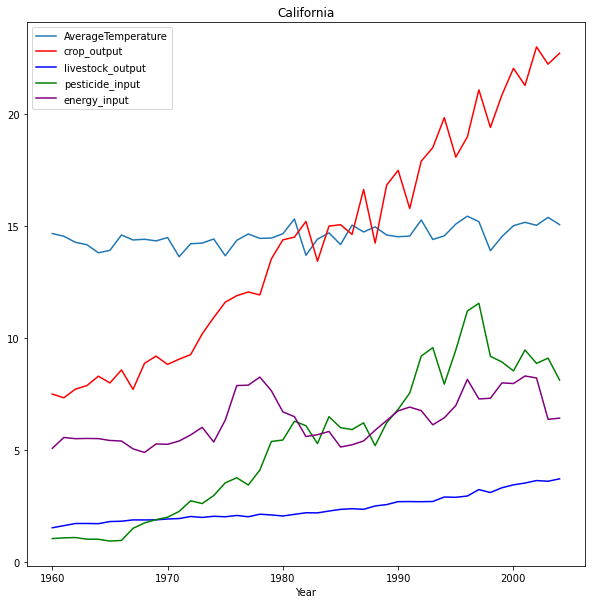

In [82]:
plt.figure(figsize=(10, 10))
ax = plt.gca()
ca_data.plot(kind='line',x='Year',y='AverageTemperature',ax=ax)
ca_data.plot(kind='line',x='Year',y='crop_output', color='red', ax=ax)
ca_data.plot(kind='line',x='Year',y='livestock_output', color='blue', ax=ax)
ca_data.plot(kind='line',x='Year',y='pesticide_input', color='green', ax=ax)
ca_data.plot(kind='line',x='Year',y='energy_input', color='purple', ax=ax)
plt.title('California')
plt.show()

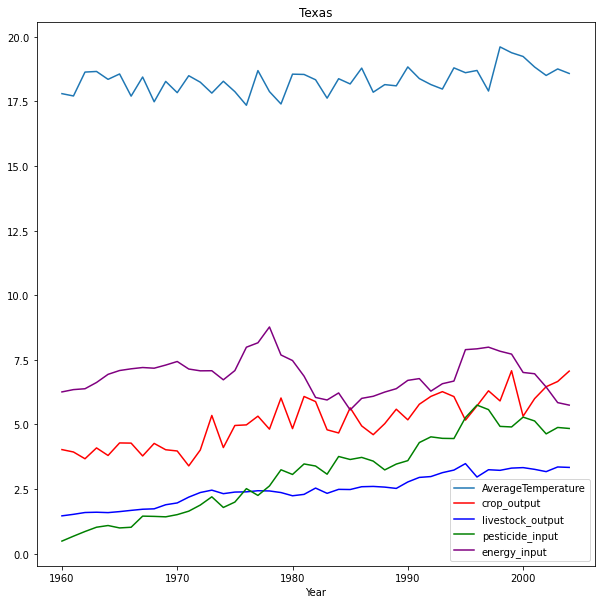

In [83]:
plt.figure(figsize=(10, 10))
ax = plt.gca()
tx_data.plot(kind='line',x='Year',y='AverageTemperature',ax=ax)
tx_data.plot(kind='line',x='Year',y='crop_output', color='red', ax=ax)
tx_data.plot(kind='line',x='Year',y='livestock_output', color='blue', ax=ax)
tx_data.plot(kind='line',x='Year',y='pesticide_input', color='green', ax=ax)
tx_data.plot(kind='line',x='Year',y='energy_input', color='purple', ax=ax)
plt.title('Texas')
plt.show()

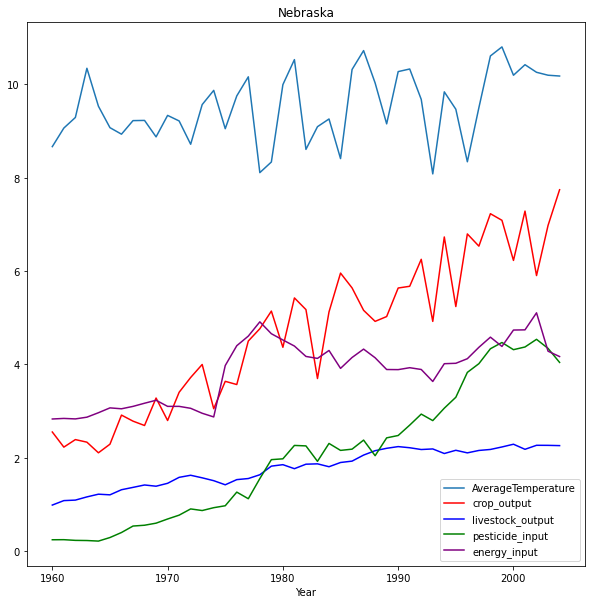

In [134]:
plt.figure(figsize=(10, 10))
ax = plt.gca()
ne_data.plot(kind='line',x='Year',y='AverageTemperature',ax=ax)
ne_data.plot(kind='line',x='Year',y='crop_output', color='red', ax=ax)
ne_data.plot(kind='line',x='Year',y='livestock_output', color='blue', ax=ax)
ne_data.plot(kind='line',x='Year',y='pesticide_input', color='green', ax=ax)
ne_data.plot(kind='line',x='Year',y='energy_input', color='purple', ax=ax)
plt.title('Nebraska')
plt.show()

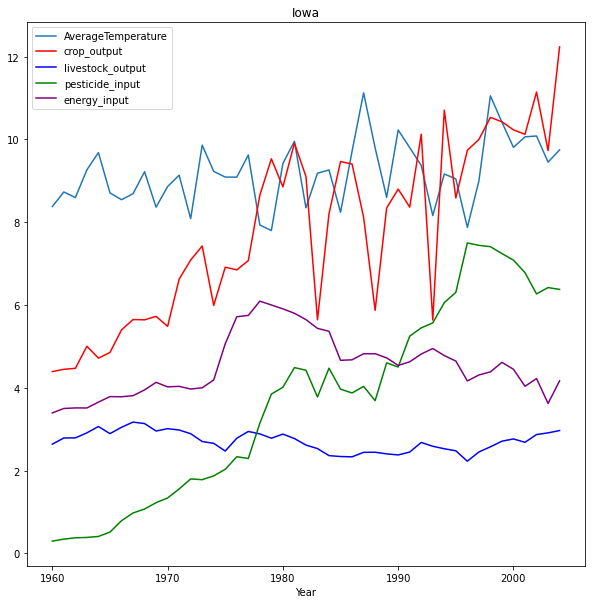

In [135]:
plt.figure(figsize=(10, 10))
ax = plt.gca()
ia_data.plot(kind='line',x='Year',y='AverageTemperature',ax=ax)
ia_data.plot(kind='line',x='Year',y='crop_output', color='red', ax=ax)
ia_data.plot(kind='line',x='Year',y='livestock_output', color='blue', ax=ax)
ia_data.plot(kind='line',x='Year',y='pesticide_input', color='green', ax=ax)
ia_data.plot(kind='line',x='Year',y='energy_input', color='purple', ax=ax)
plt.title('Iowa')
plt.show()

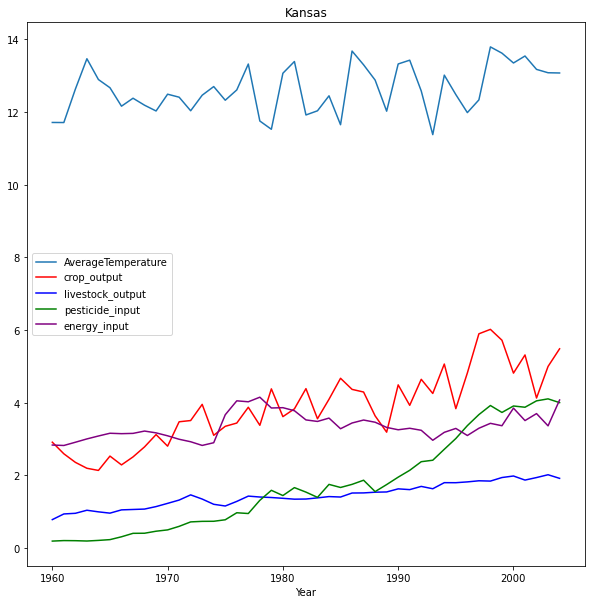

In [136]:
plt.figure(figsize=(10, 10))
ax = plt.gca()
ks_data.plot(kind='line',x='Year',y='AverageTemperature',ax=ax)
ks_data.plot(kind='line',x='Year',y='crop_output', color='red', ax=ax)
ks_data.plot(kind='line',x='Year',y='livestock_output', color='blue', ax=ax)
ks_data.plot(kind='line',x='Year',y='pesticide_input', color='green', ax=ax)
ks_data.plot(kind='line',x='Year',y='energy_input', color='purple', ax=ax)
plt.title('Kansas')
plt.show()

## United States General Analysis

### Data

In [94]:
states_shp = gpd.read_file('../data/us_states_carto/cb_2018_us_state_20m.shp')
states_shp

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,24,01714934,0400000US24,24,MD,Maryland,00,25151100280,6979966958,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ..."
1,19,01779785,0400000US19,19,IA,Iowa,00,144661267977,1084180812,"POLYGON ((-96.62187 42.77925, -96.57794 42.827..."
2,10,01779781,0400000US10,10,DE,Delaware,00,5045925646,1399985648,"POLYGON ((-75.77379 39.72220, -75.75323 39.757..."
3,39,01085497,0400000US39,39,OH,Ohio,00,105828882568,10268850702,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ..."
4,42,01779798,0400000US42,42,PA,Pennsylvania,00,115884442321,3394589990,"POLYGON ((-80.51989 40.90666, -80.51964 40.987..."
...,...,...,...,...,...,...,...,...,...,...
47,23,01779787,0400000US23,23,ME,Maine,00,79887426037,11746549764,"MULTIPOLYGON (((-68.92401 43.88541, -68.87478 ..."
48,15,01779782,0400000US15,15,HI,Hawaii,00,16633990195,11777809026,"MULTIPOLYGON (((-156.04965 19.78045, -156.0062..."
49,33,01779794,0400000US33,33,NH,New Hampshire,00,23189413166,1026675248,"POLYGON ((-72.55611 42.86625, -72.53147 42.897..."
50,04,01779777,0400000US04,04,AZ,Arizona,00,294198551143,1027337603,"POLYGON ((-114.79968 32.59362, -114.80939 32.6..."


<AxesSubplot:>

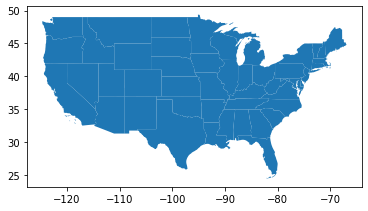

In [95]:
# remove Hawaii, Alaska, and Puerto Rico
no_AK = (states_shp['STUSPS'] != 'AK') 
no_HI = (states_shp['STUSPS'] != 'HI') 
no_PR = (states_shp['STUSPS'] != 'PR')
states_shp = states_shp[no_AK & no_HI & no_PR]
states_shp.plot()

In [96]:
states_gis = states_shp[['STUSPS', 'geometry']]
states_gis

,STUSPS,geometry
0,MD,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ..."
1,IA,"POLYGON ((-96.62187 42.77925, -96.57794 42.827..."
2,DE,"POLYGON ((-75.77379 39.72220, -75.75323 39.757..."
3,OH,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ..."
4,PA,"POLYGON ((-80.51989 40.90666, -80.51964 40.987..."
5,NE,"POLYGON ((-104.05314 41.11446, -104.05245 41.2..."
6,WA,"MULTIPOLYGON (((-123.23715 48.68347, -123.0704..."
8,AL,"POLYGON ((-88.46866 31.89386, -88.46866 31.933..."
9,AR,"POLYGON ((-94.61792 36.49941, -94.36120 36.499..."
10,NM,"POLYGON ((-109.04919 31.79655, -109.04830 32.0..."


In [97]:
state_temp

,Year,State,AverageTemperature,State_Ab
0,1960,Alabama,16.613667,AL
1,1961,Alabama,16.850917,AL
2,1962,Alabama,17.426167,AL
3,1963,Alabama,16.729750,AL
4,1964,Alabama,17.126000,AL
...,...,...,...,...
2641,2009,Wyoming,5.199917,WY
2642,2010,Wyoming,5.756417,WY
2643,2011,Wyoming,5.312250,WY
2644,2012,Wyoming,7.306167,WY


In [98]:
state_temp = state_temp.merge(states_gis, left_on='State_Ab', right_on='STUSPS')
state_temp = state_temp.drop(columns=['STUSPS'])
state_temp

,Year,State,AverageTemperature,State_Ab,geometry
0,1960,Alabama,16.613667,AL,"POLYGON ((-88.46866 31.89386, -88.46866 31.933..."
1,1961,Alabama,16.850917,AL,"POLYGON ((-88.46866 31.89386, -88.46866 31.933..."
2,1962,Alabama,17.426167,AL,"POLYGON ((-88.46866 31.89386, -88.46866 31.933..."
3,1963,Alabama,16.729750,AL,"POLYGON ((-88.46866 31.89386, -88.46866 31.933..."
4,1964,Alabama,17.126000,AL,"POLYGON ((-88.46866 31.89386, -88.46866 31.933..."
...,...,...,...,...,...
2533,2009,Wyoming,5.199917,WY,"POLYGON ((-111.05689 44.86666, -111.04432 45.0..."
2534,2010,Wyoming,5.756417,WY,"POLYGON ((-111.05689 44.86666, -111.04432 45.0..."
2535,2011,Wyoming,5.312250,WY,"POLYGON ((-111.05689 44.86666, -111.04432 45.0..."
2536,2012,Wyoming,7.306167,WY,"POLYGON ((-111.05689 44.86666, -111.04432 45.0..."


In [99]:
state_temp_1960 = state_temp[state_temp['Year'] == 1960]
state_temp_1960

,Year,State,AverageTemperature,State_Ab,geometry
0,1960,Alabama,16.613667,AL,"POLYGON ((-88.46866 31.89386, -88.46866 31.933..."
54,1960,Arizona,15.537417,AZ,"POLYGON ((-114.79968 32.59362, -114.80939 32.6..."
108,1960,Arkansas,15.133583,AR,"POLYGON ((-94.61792 36.49941, -94.36120 36.499..."
162,1960,California,14.671250,CA,"MULTIPOLYGON (((-118.59397 33.46720, -118.4847..."
216,1960,Colorado,6.898083,CO,"POLYGON ((-109.05996 38.49999, -109.05151 39.1..."
270,1960,Connecticut,9.450750,CT,"POLYGON ((-73.69594 41.11526, -73.48271 41.212..."
324,1960,Delaware,11.991667,DE,"POLYGON ((-75.77379 39.72220, -75.75323 39.757..."
378,1960,Florida,21.251833,FL,"MULTIPOLYGON (((-81.81169 24.56874, -81.75127 ..."
432,1960,Idaho,5.452000,ID,"POLYGON ((-117.24303 44.39097, -117.21507 44.4..."
486,1960,Illinois,10.522917,IL,"POLYGON ((-91.50626 40.20016, -91.49696 40.248..."


In [100]:
state_temp_1970 = state_temp[state_temp['Year'] == 1970]
state_temp_1970

,Year,State,AverageTemperature,State_Ab,geometry
10,1970,Alabama,17.082750,AL,"POLYGON ((-88.46866 31.89386, -88.46866 31.933..."
64,1970,Arizona,15.191083,AZ,"POLYGON ((-114.79968 32.59362, -114.80939 32.6..."
118,1970,Arkansas,15.614167,AR,"POLYGON ((-94.61792 36.49941, -94.36120 36.499..."
172,1970,California,14.492167,CA,"MULTIPOLYGON (((-118.59397 33.46720, -118.4847..."
226,1970,Colorado,6.946750,CO,"POLYGON ((-109.05996 38.49999, -109.05151 39.1..."
280,1970,Connecticut,9.320250,CT,"POLYGON ((-73.69594 41.11526, -73.48271 41.212..."
334,1970,Delaware,12.167000,DE,"POLYGON ((-75.77379 39.72220, -75.75323 39.757..."
388,1970,Florida,21.327833,FL,"MULTIPOLYGON (((-81.81169 24.56874, -81.75127 ..."
442,1970,Idaho,5.519667,ID,"POLYGON ((-117.24303 44.39097, -117.21507 44.4..."
496,1970,Illinois,11.053083,IL,"POLYGON ((-91.50626 40.20016, -91.49696 40.248..."


In [101]:
state_temp_1980 = state_temp[state_temp['Year'] == 1980]
state_temp_1980

,Year,State,AverageTemperature,State_Ab,geometry
20,1980,Alabama,17.286833,AL,"POLYGON ((-88.46866 31.89386, -88.46866 31.933..."
74,1980,Arizona,15.824250,AZ,"POLYGON ((-114.79968 32.59362, -114.80939 32.6..."
128,1980,Arkansas,16.108250,AR,"POLYGON ((-94.61792 36.49941, -94.36120 36.499..."
182,1980,California,14.662583,CA,"MULTIPOLYGON (((-118.59397 33.46720, -118.4847..."
236,1980,Colorado,7.661250,CO,"POLYGON ((-109.05996 38.49999, -109.05151 39.1..."
290,1980,Connecticut,9.267667,CT,"POLYGON ((-73.69594 41.11526, -73.48271 41.212..."
344,1980,Delaware,12.208083,DE,"POLYGON ((-75.77379 39.72220, -75.75323 39.757..."
398,1980,Florida,21.673500,FL,"MULTIPOLYGON (((-81.81169 24.56874, -81.75127 ..."
452,1980,Idaho,5.915167,ID,"POLYGON ((-117.24303 44.39097, -117.21507 44.4..."
506,1980,Illinois,11.110583,IL,"POLYGON ((-91.50626 40.20016, -91.49696 40.248..."


In [102]:
state_temp_1990 = state_temp[state_temp['Year'] == 1990]
state_temp_1990

,Year,State,AverageTemperature,State_Ab,geometry
30,1990,Alabama,18.536500,AL,"POLYGON ((-88.46866 31.89386, -88.46866 31.933..."
84,1990,Arizona,15.531250,AZ,"POLYGON ((-114.79968 32.59362, -114.80939 32.6..."
138,1990,Arkansas,16.870083,AR,"POLYGON ((-94.61792 36.49941, -94.36120 36.499..."
192,1990,California,14.527583,CA,"MULTIPOLYGON (((-118.59397 33.46720, -118.4847..."
246,1990,Colorado,7.471500,CO,"POLYGON ((-109.05996 38.49999, -109.05151 39.1..."
300,1990,Connecticut,10.831250,CT,"POLYGON ((-73.69594 41.11526, -73.48271 41.212..."
354,1990,Delaware,13.723833,DE,"POLYGON ((-75.77379 39.72220, -75.75323 39.757..."
408,1990,Florida,22.901500,FL,"MULTIPOLYGON (((-81.81169 24.56874, -81.75127 ..."
462,1990,Idaho,5.931167,ID,"POLYGON ((-117.24303 44.39097, -117.21507 44.4..."
516,1990,Illinois,12.295500,IL,"POLYGON ((-91.50626 40.20016, -91.49696 40.248..."


In [103]:
state_temp_2000 = state_temp[state_temp['Year'] == 2000]
state_temp_2000

,Year,State,AverageTemperature,State_Ab,geometry
40,2000,Alabama,17.911333,AL,"POLYGON ((-88.46866 31.89386, -88.46866 31.933..."
94,2000,Arizona,16.510250,AZ,"POLYGON ((-114.79968 32.59362, -114.80939 32.6..."
148,2000,Arkansas,16.362583,AR,"POLYGON ((-94.61792 36.49941, -94.36120 36.499..."
202,2000,California,15.019333,CA,"MULTIPOLYGON (((-118.59397 33.46720, -118.4847..."
256,2000,Colorado,8.204833,CO,"POLYGON ((-109.05996 38.49999, -109.05151 39.1..."
310,2000,Connecticut,9.581000,CT,"POLYGON ((-73.69594 41.11526, -73.48271 41.212..."
364,2000,Delaware,12.347583,DE,"POLYGON ((-75.77379 39.72220, -75.75323 39.757..."
418,2000,Florida,21.952000,FL,"MULTIPOLYGON (((-81.81169 24.56874, -81.75127 ..."
472,2000,Idaho,6.239000,ID,"POLYGON ((-117.24303 44.39097, -117.21507 44.4..."
526,2000,Illinois,11.582917,IL,"POLYGON ((-91.50626 40.20016, -91.49696 40.248..."


In [104]:
state_temp_1960 = gpd.GeoDataFrame(state_temp_1960, geometry='geometry')
state_temp_1970 = gpd.GeoDataFrame(state_temp_1970, geometry='geometry')
state_temp_1980 = gpd.GeoDataFrame(state_temp_1980, geometry='geometry')
state_temp_1990 = gpd.GeoDataFrame(state_temp_1990, geometry='geometry')
state_temp_2000 = gpd.GeoDataFrame(state_temp_2000, geometry='geometry')

<AxesSubplot:>

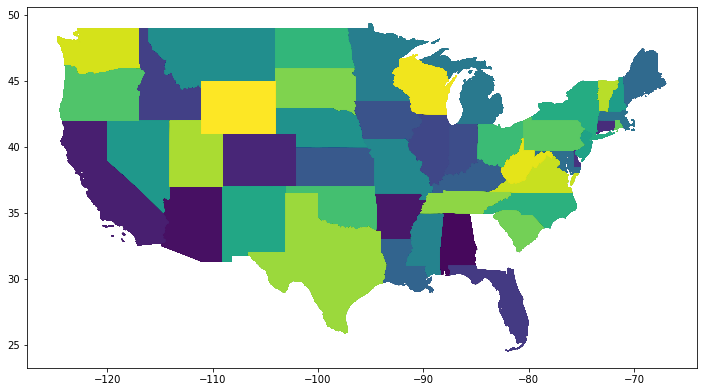

In [105]:
state_gdf = gpd.GeoDataFrame(state_temp, geometry='geometry')
state_gdf.plot(cmap='viridis', figsize=(12, 12))

In [107]:
crops_l = pd.melt(crops, id_vars=['Year'], value_name='crop_output')
crops_l = crops_l.merge(states_gis, left_on='variable', right_on='STUSPS')
crops_l = crops_l.drop(columns=['STUSPS'])
crops_l

,Year,variable,crop_output,geometry
0,1960,AL,0.863020,"POLYGON ((-88.46866 31.89386, -88.46866 31.933..."
1,1961,AL,0.816691,"POLYGON ((-88.46866 31.89386, -88.46866 31.933..."
2,1962,AL,0.738305,"POLYGON ((-88.46866 31.89386, -88.46866 31.933..."
3,1963,AL,0.935998,"POLYGON ((-88.46866 31.89386, -88.46866 31.933..."
4,1964,AL,0.897049,"POLYGON ((-88.46866 31.89386, -88.46866 31.933..."
...,...,...,...,...
2155,2000,WY,0.376173,"POLYGON ((-111.05689 44.86666, -111.04432 45.0..."
2156,2001,WY,0.330989,"POLYGON ((-111.05689 44.86666, -111.04432 45.0..."
2157,2002,WY,0.270746,"POLYGON ((-111.05689 44.86666, -111.04432 45.0..."
2158,2003,WY,0.374374,"POLYGON ((-111.05689 44.86666, -111.04432 45.0..."


In [111]:
crops_1970 = crops_l[crops_l['Year'] == 1970]
crops_1970

,Year,variable,crop_output,geometry
10,1970,AL,0.676867,"POLYGON ((-88.46866 31.89386, -88.46866 31.933..."
55,1970,AR,1.656506,"POLYGON ((-94.61792 36.49941, -94.36120 36.499..."
100,1970,AZ,0.896517,"POLYGON ((-114.79968 32.59362, -114.80939 32.6..."
145,1970,CA,8.832390,"MULTIPOLYGON (((-118.59397 33.46720, -118.4847..."
190,1970,CO,1.250153,"POLYGON ((-109.05996 38.49999, -109.05151 39.1..."
235,1970,CT,0.183244,"POLYGON ((-73.69594 41.11526, -73.48271 41.212..."
280,1970,DE,0.138412,"POLYGON ((-75.77379 39.72220, -75.75323 39.757..."
325,1970,FL,2.778518,"MULTIPOLYGON (((-81.81169 24.56874, -81.75127 ..."
370,1970,GA,1.271160,"POLYGON ((-85.60516 34.98468, -85.47434 34.983..."
415,1970,IA,5.486956,"POLYGON ((-96.62187 42.77925, -96.57794 42.827..."


In [112]:
crops_1980 = crops_l[crops_l['Year'] == 1980]
crops_1980

,Year,variable,crop_output,geometry
20,1980,AL,0.875171,"POLYGON ((-88.46866 31.89386, -88.46866 31.933..."
65,1980,AR,1.692223,"POLYGON ((-94.61792 36.49941, -94.36120 36.499..."
110,1980,AZ,1.221880,"POLYGON ((-114.79968 32.59362, -114.80939 32.6..."
155,1980,CA,14.389781,"MULTIPOLYGON (((-118.59397 33.46720, -118.4847..."
200,1980,CO,1.673125,"POLYGON ((-109.05996 38.49999, -109.05151 39.1..."
245,1980,CT,0.190731,"POLYGON ((-73.69594 41.11526, -73.48271 41.212..."
290,1980,DE,0.139793,"POLYGON ((-75.77379 39.72220, -75.75323 39.757..."
335,1980,FL,4.613510,"MULTIPOLYGON (((-81.81169 24.56874, -81.75127 ..."
380,1980,GA,1.489077,"POLYGON ((-85.60516 34.98468, -85.47434 34.983..."
425,1980,IA,8.854717,"POLYGON ((-96.62187 42.77925, -96.57794 42.827..."


In [116]:
crops_1990 = crops_l[crops_l['Year'] == 1990]
crops_1990

,Year,variable,crop_output,geometry
30,1990,AL,0.803265,"POLYGON ((-88.46866 31.89386, -88.46866 31.933..."
75,1990,AR,2.536384,"POLYGON ((-94.61792 36.49941, -94.36120 36.499..."
120,1990,AZ,1.144400,"POLYGON ((-114.79968 32.59362, -114.80939 32.6..."
165,1990,CA,17.489463,"MULTIPOLYGON (((-118.59397 33.46720, -118.4847..."
210,1990,CO,1.823267,"POLYGON ((-109.05996 38.49999, -109.05151 39.1..."
255,1990,CT,0.232518,"POLYGON ((-73.69594 41.11526, -73.48271 41.212..."
300,1990,DE,0.223155,"POLYGON ((-75.77379 39.72220, -75.75323 39.757..."
345,1990,FL,4.759074,"MULTIPOLYGON (((-81.81169 24.56874, -81.75127 ..."
390,1990,GA,1.729382,"POLYGON ((-85.60516 34.98468, -85.47434 34.983..."
435,1990,IA,8.801647,"POLYGON ((-96.62187 42.77925, -96.57794 42.827..."


In [110]:
crops_2000 = crops_l[crops_l['Year'] == 2000]
crops_2000

,Year,variable,crop_output,geometry
40,2000,AL,0.763403,"POLYGON ((-88.46866 31.89386, -88.46866 31.933..."
85,2000,AR,2.859711,"POLYGON ((-94.61792 36.49941, -94.36120 36.499..."
130,2000,AZ,1.592129,"POLYGON ((-114.79968 32.59362, -114.80939 32.6..."
175,2000,CA,22.039649,"MULTIPOLYGON (((-118.59397 33.46720, -118.4847..."
220,2000,CO,2.114670,"POLYGON ((-109.05996 38.49999, -109.05151 39.1..."
265,2000,CT,0.326116,"POLYGON ((-73.69594 41.11526, -73.48271 41.212..."
310,2000,DE,0.263059,"POLYGON ((-75.77379 39.72220, -75.75323 39.757..."
355,2000,FL,6.102425,"MULTIPOLYGON (((-81.81169 24.56874, -81.75127 ..."
400,2000,GA,2.415683,"POLYGON ((-85.60516 34.98468, -85.47434 34.983..."
445,2000,IA,10.232174,"POLYGON ((-96.62187 42.77925, -96.57794 42.827..."


In [108]:
crops_l = gpd.GeoDataFrame(crops_l, geometry='geometry')

<AxesSubplot:title={'center':'Crop Output by State, 1970'}>

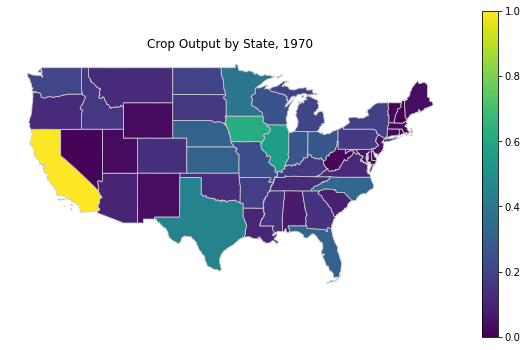

In [113]:
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
ax.set_title('Crop Output by State, 1970')
sm = plt.cm.ScalarMappable(cmap='viridis')
sm.set_array([]) 
fig.colorbar(sm)
crops_1970.plot(column='crop_output', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8')

In [120]:
crops.columns

Index(['Year', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'IA',
       'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO',
       'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK',
       'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI',
       'WV', 'WY'],
      dtype='object')

<AxesSubplot:title={'center':'Crop Output by State, 1960'}>

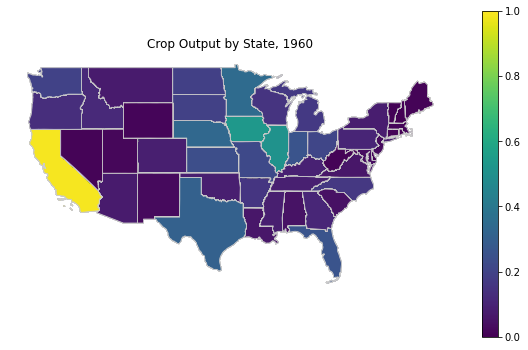

In [109]:
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
ax.set_title('Crop Output by State, 1960')
sm = plt.cm.ScalarMappable(cmap='viridis')
sm.set_array([]) 
fig.colorbar(sm)
crops_l.plot(column='crop_output', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8')

<AxesSubplot:title={'center':'Crop Output by State, 1980'}>

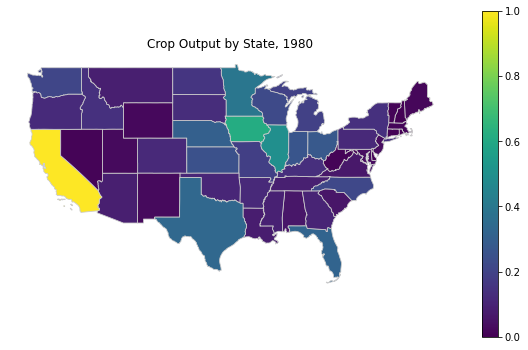

In [114]:
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
ax.set_title('Crop Output by State, 1980')
sm = plt.cm.ScalarMappable(cmap='viridis')
sm.set_array([]) 
fig.colorbar(sm)
crops_1980.plot(column='crop_output', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8')

<AxesSubplot:title={'center':'Crop Output by State, 1990'}>

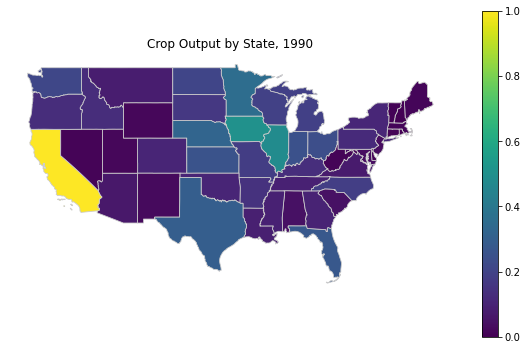

In [117]:
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
ax.set_title('Crop Output by State, 1990')
sm = plt.cm.ScalarMappable(cmap='viridis')
sm.set_array([]) 
fig.colorbar(sm)
crops_1990.plot(column='crop_output', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8')

<AxesSubplot:title={'center':'Crop Output by State, 2000'}>

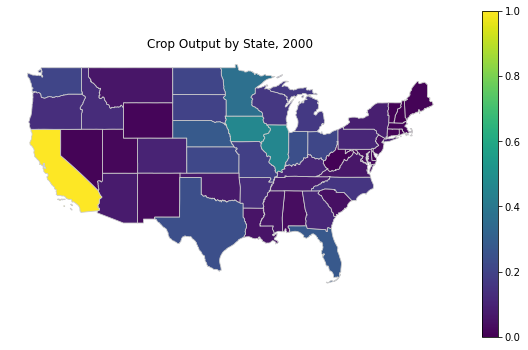

In [119]:
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
ax.set_title('Crop Output by State, 2000')
sm = plt.cm.ScalarMappable(cmap='viridis')
sm.set_array([]) 
fig.colorbar(sm)
crops_2000.plot(column='crop_output', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8')

<AxesSubplot:title={'center':'Average Temperatures by State, 1960'}>

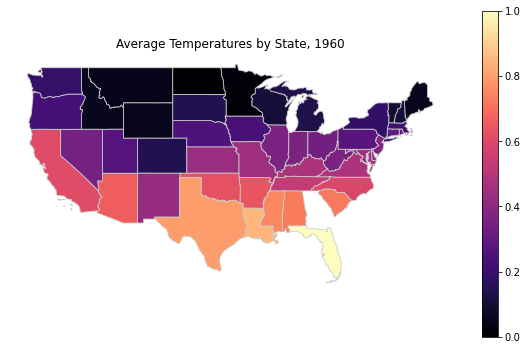

In [106]:
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
ax.set_title('Average Temperatures by State, 1960')
sm = plt.cm.ScalarMappable(cmap='magma')
sm.set_array([]) 
fig.colorbar(sm)
state_temp_1960.plot(column='AverageTemperature', cmap='magma', linewidth=0.8, ax=ax, edgecolor='0.8')

<AxesSubplot:title={'center':'Average Temperatures by State, 1970'}>

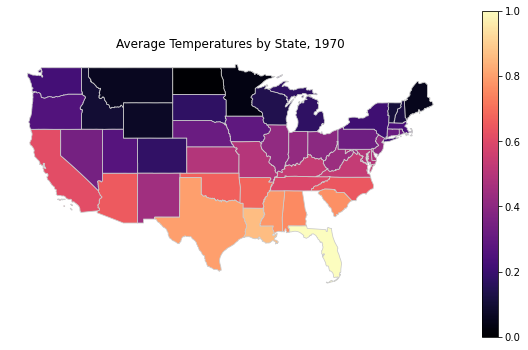

In [121]:
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
ax.set_title('Average Temperatures by State, 1970')
sm = plt.cm.ScalarMappable(cmap='magma')
sm.set_array([]) 
fig.colorbar(sm)
state_temp_1970.plot(column='AverageTemperature', cmap='magma', linewidth=0.8, ax=ax, edgecolor='0.8')

<AxesSubplot:title={'center':'Average Temperatures by State, 1980'}>

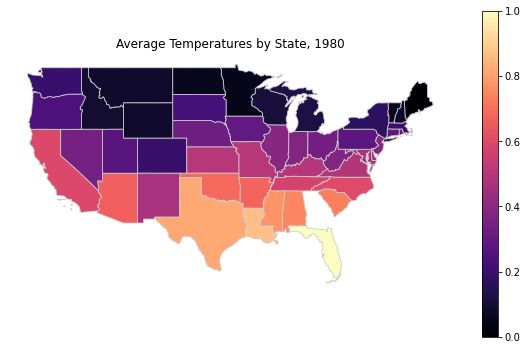

In [122]:
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
ax.set_title('Average Temperatures by State, 1980')
sm = plt.cm.ScalarMappable(cmap='magma')
sm.set_array([]) 
fig.colorbar(sm)
state_temp_1980.plot(column='AverageTemperature', cmap='magma', linewidth=0.8, ax=ax, edgecolor='0.8')

<AxesSubplot:title={'center':'Average Temperatures by State, 1990'}>

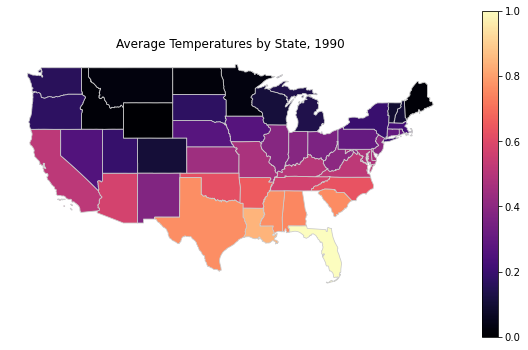

In [123]:
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
ax.set_title('Average Temperatures by State, 1990')
sm = plt.cm.ScalarMappable(cmap='magma')
sm.set_array([]) 
fig.colorbar(sm)
state_temp_1990.plot(column='AverageTemperature', cmap='magma', linewidth=0.8, ax=ax, edgecolor='0.8')

<AxesSubplot:title={'center':'Average Temperatures by State, 2000'}>

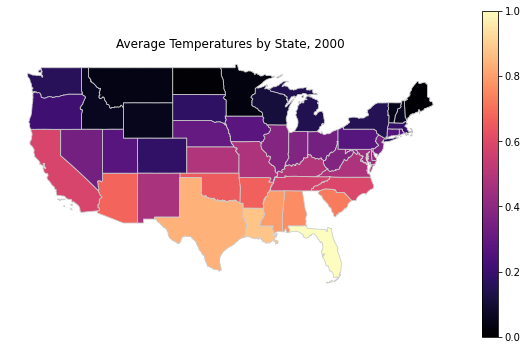

In [124]:
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
ax.set_title('Average Temperatures by State, 2000')
sm = plt.cm.ScalarMappable(cmap='magma')
sm.set_array([]) 
fig.colorbar(sm)
state_temp_2000.plot(column='AverageTemperature', cmap='magma', linewidth=0.8, ax=ax, edgecolor='0.8')